# 4. If and Loops — Finance Practice 

This notebook follows the **same topics and order** as the original Lecture 3 (`If and Loops`). All tasks use **real financial/economic data** from Peru and the US.

**Student rule:** fill only the `TODO` blocks. Do *not* paste full solutions from elsewhere.

## Data sources used

- **BCRPData (Peru, official)**: BCRP statistical series API.
  - API guide: https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api
  - Example daily series list includes BVL indexes and FX.
- **Yahoo Finance (US market data)** via `yfinance` (community wrapper for Yahoo Finance).
  - Docs: https://ranaroussi.github.io/yfinance/
- **SEC EDGAR Data APIs (US, official)**: company facts JSON.
  - Docs: https://www.sec.gov/search-filings/edgar-application-programming-interfaces

If any download fails (internet/firewall), this notebook is designed to **keep running** with empty data, so you can still practice control flow syntax.

In [453]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 120)


In [454]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
import warnings

import numpy as np
import pandas as pd

CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

warnings.filterwarnings("ignore")

_ES_TO_EN_MONTH = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

def _hash_key(*parts: str) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _normalize_period(code: str, period: str | None) -> str | None:
    if period is None:
        return None
    period = str(period).strip()
    freq = code[-2:].upper() if len(code) >= 2 else ""

    if freq == "PD":  # daily
        if re.fullmatch(r"\d{4}-\d{1,2}", period):
            y, m = period.split("-")
            return f"{int(y):04d}-{int(m):02d}-01"
        if re.fullmatch(r"\d{4}", period):
            return f"{int(period):04d}-01-01"
        return period

    if freq == "PM":  # monthly
        m = re.fullmatch(r"(\d{4})-(\d{1,2})-(\d{1,2})", period)
        if m:
            y, mo, _ = m.groups()
            return f"{int(y):04d}-{int(mo)}"
        m = re.fullmatch(r"(\d{4})-(\d{1,2})", period)
        if m:
            y, mo = m.groups()
            return f"{int(y):04d}-{int(mo)}"
        if re.fullmatch(r"\d{4}", period):
            return f"{int(period):04d}-1"
        return period

    if freq == "MD":  # daily index
        return period

    return period

def _parse_bcrp_period_name(name: str) -> pd.Timestamp:
    s = str(name).strip()

    # ISO-ish
    try:
        if re.fullmatch(r"\d{4}(-\d{1,2}){0,2}", s):
            return pd.to_datetime(s, errors="raise")
    except Exception:
        pass

    # Monthly like "Mar.2020"
    m = re.fullmatch(r"([A-Za-zÁÉÍÓÚÑñ]{3})\.(\d{4})", s)
    if m:
        mon_es, y = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        return pd.to_datetime(f"{mon}.{y}", format="%b.%Y", errors="coerce")

    # Daily like "18Nov25" or "02Ene97"
    m = re.fullmatch(r"(\d{2})([A-Za-zÁÉÍÓÚÑñ]{3})(\d{2})", s)
    if m:
        d, mon_es, yy = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        year = 2000 + int(yy) if int(yy) <= 69 else 1900 + int(yy)
        return pd.to_datetime(f"{d}{mon}{year}", format="%d%b%Y", errors="coerce")

    return pd.to_datetime(s, errors="coerce")

def bcrp_get(series_codes, start: str | None = None, end: str | None = None, lang: str = "esp") -> pd.DataFrame:
    """Fetch BCRPData series (official API) into a DataFrame.

    Returns columns: ["date", <code1>, <code2>, ...]
    """
    try:
        import requests
    except Exception:
        return pd.DataFrame()

    if isinstance(series_codes, (list, tuple)):
        codes_list = [str(c).strip() for c in series_codes]
        codes = "-".join(codes_list)
        freq_code = codes_list[0]
    else:
        codes = str(series_codes).strip()
        codes_list = codes.split("-")
        freq_code = codes_list[0]

    start_n = _normalize_period(freq_code, start)
    end_n = _normalize_period(freq_code, end)

    key = _hash_key("bcrp", codes, start_n or "", end_n or "", lang)
    cache_path = CACHE_DIR / f"bcrp_{key}.pkl"
    if cache_path.exists():
        return pd.read_pickle(cache_path)

    base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
    parts = [base_url, codes, "json"]
    if start_n and end_n:
        parts += [start_n, end_n]
    if lang:
        parts += [lang]
    url = "/".join(parts)

    r = requests.get(url, timeout=30)
    r.raise_for_status()
    obj = r.json()

    periods = obj.get("periods", [])
    rows = []
    for p in periods:
        name = p.get("name")
        vals = p.get("values", [])
        if isinstance(vals, str):
            vals = [vals]
        if name is None or not isinstance(vals, list):
            continue
        vals = (vals + [None] * len(codes_list))[:len(codes_list)]
        rows.append([name] + vals)

    df = pd.DataFrame(rows, columns=["date"] + codes_list)
    if df.shape[0] == 0:
        return pd.DataFrame(columns=["date"] + codes_list)

    df["date"] = df["date"].apply(_parse_bcrp_period_name)
    for c in codes_list:
        df[c] = df[c].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan})
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    df.to_pickle(cache_path)
    return df

def bcrp_get_cached_or_empty(series_codes, start: str, end: str) -> pd.DataFrame:
    try:
        return bcrp_get(series_codes, start=start, end=end)
    except Exception:
        if isinstance(series_codes, (list, tuple)):
            codes_list = [str(c).strip() for c in series_codes]
        else:
            codes_list = [str(series_codes).strip()]
        return pd.DataFrame(columns=["date"] + codes_list)

def yf_download_wide(tickers, start: str, end: str) -> pd.DataFrame:
    """Download Close and Volume using yfinance.

    Returns a DataFrame indexed by date with columns:
      Close_<TICKER>, Volume_<TICKER>
    """
    try:
        import yfinance as yf
    except Exception:
        return pd.DataFrame()

    cols = tickers if isinstance(tickers, (list, tuple)) else [tickers]
    key = _hash_key("yf_wide", ",".join(cols), start, end)
    cache_path = CACHE_DIR / f"yf_wide_{key}.pkl"
    if cache_path.exists():
        return pd.read_pickle(cache_path)

    try:
        data = yf.download(cols, start=start, end=end, auto_adjust=True, progress=False)
        if data.empty:
            return pd.DataFrame()
        if isinstance(data.columns, pd.MultiIndex):
            close = data["Close"].copy()
            vol = data["Volume"].copy()
        else:
            close = data[["Close"]].rename(columns={"Close": cols[0]})
            vol = data[["Volume"]].rename(columns={"Volume": cols[0]})
        close = close.add_prefix("Close_")
        vol = vol.add_prefix("Volume_")
        out = close.join(vol, how="outer")
        out.index.name = "date"
        out.to_pickle(cache_path)
        return out
    except Exception:
        return pd.DataFrame()

def sec_companyfacts(cik10: str, user_agent: str) -> dict:
    """Fetch SEC company facts (official EDGAR Data APIs).

    Endpoint:
      https://data.sec.gov/api/xbrl/companyfacts/CIK##########.json

    The SEC requires a User-Agent identifying the requester.

    Returns {} on failure.
    """
    try:
        import requests, json
    except Exception:
        return {}

    cik10 = str(cik10).zfill(10)
    key = _hash_key("sec_companyfacts", cik10)
    cache_path = CACHE_DIR / f"sec_companyfacts_{key}.json"
    if cache_path.exists():
        try:
            return json.loads(cache_path.read_text(encoding="utf-8"))
        except Exception:
            pass

    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik10}.json"
    headers = {"User-Agent": user_agent, "Accept-Encoding": "gzip, deflate", "Host": "data.sec.gov"}

    try:
        r = requests.get(url, headers=headers, timeout=30)
        r.raise_for_status()
        obj = r.json()
        try:
            cache_path.write_text(json.dumps(obj), encoding="utf-8")
        except Exception:
            pass
        return obj
    except Exception:
        return {}

def safe_head(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    return df.head(n) if isinstance(df, pd.DataFrame) else pd.DataFrame()

### Load datasets (used across exercises)

We load:
- Peru: **BVL General Index** (BCRP series `PD38026MD`) and **CPI Non-Tradables** (monthly, `PN01282PM`).
- US: prices/volumes for selected tickers via `yfinance`.
- US fundamentals: SEC company facts (optional) for Apple (CIK 0000320193).


In [455]:
START = "2021-01-01"
END = "2025-12-18"

# Peru — BCRPData (official)
bvl = bcrp_get_cached_or_empty("PD38026MD", start=START, end=END).rename(columns={"PD38026MD":"BVL_index"})
cpi_nt = bcrp_get_cached_or_empty("PN01282PM", start=START, end=END).rename(columns={"PN01282PM":"CPI_non_tradables"})

# US — Yahoo Finance (real market data)
tickers = ["SPY", "AAPL", "MSFT", "JPM", "NVDA"]
us = yf_download_wide(tickers, start=START, end=END)

print("BVL:", bvl.shape, "CPI NT:", cpi_nt.shape, "US:", us.shape)
safe_head(bvl), safe_head(cpi_nt), safe_head(us)

BVL: (729, 2) CPI NT: (59, 2) US: (1246, 10)


(        date  BVL_index
 0 2021-02-01   21610.03
 1 2021-02-02   21451.89
 2 2021-02-03   21632.78
 3 2021-02-04   21552.20
 4 2021-02-05   21783.37,
         date  CPI_non_tradables
 0 2021-01-01           0.832155
 1 2021-02-01          -0.424668
 2 2021-03-01           1.026397
 3 2021-04-01          -0.361899
 4 2021-05-01           0.158005,
 Ticker      Close_AAPL   Close_JPM  Close_MSFT  Close_NVDA   Close_SPY  \
 date                                                                     
 2021-01-04  125.974464  110.548325  208.882187   13.076725  344.256744   
 2021-01-05  127.531998  111.149834  209.083725   13.367158  346.627838   
 2021-01-06  123.239059  116.369003  203.662292   12.579125  348.700043   
 2021-01-07  127.444405  120.190445  209.457932   13.306580  353.880920   
 2021-01-08  128.544373  120.323174  210.734116   13.239519  355.897186   
 
 Ticker      Volume_AAPL  Volume_JPM  Volume_MSFT  Volume_NVDA  Volume_SPY  
 date                                         

# 4.1. <a id='def'> If condition </a>

In this section you will practice `if / elif / else` using real data.

## 4.1.1.  <a id='4.1.1.'> The structure of the code </a>

**Exercise 4.1.1 — Classify a day (single `if`)**

Using the **BVL index**:
1. Compute daily returns: `ret = pct_change()`.
2. Take the most recent non-missing return.
3. Write a single `if` statement that prints a message only when the last return is **positive**.

Keep it minimal: one `if`, one `print`.

In [456]:
# Solution (Exercise 4.1.1)
# bvl is expected to have columns: ["date", "BVL_index"]

last_ret = np.nan  # We start with "no value yet", just in case something goes wrong.

try:
    # We treat the BVL index as a time series:
    # - set_index("date") makes the dates the index (so pandas knows the timeline)
    # - ["BVL_index"] selects the index level/price series
    # - pct_change() computes the day-to-day return:
    #     return_t = (BVL_t / BVL_{t-1}) - 1
    ret = bvl.set_index("date")["BVL_index"].pct_change()

    # The first return is usually missing (because there is no previous day),
    # so we drop missing values and then take the last available return.
    last_ret = float(ret.dropna().iloc[-1])
except Exception:
    # If bvl is empty, the column is missing, or the format is not correct,
    # we simply keep last_ret as NaN and move on.
    pass

# The exercise asks for ONE if-statement that prints ONLY when the last return is positive.
# So: if we successfully computed a number AND it is greater than 0, we print the message.
if pd.notna(last_ret) and last_ret > 0:
    print("BVL last return is positive:", last_ret)


BVL last return is positive: 0.01196384727960198


### 4.1.2.   <a id='4.1.2.'> If condition with more than 1 expression </a>

**Exercise 4.1.2 — Two conditions with `and` / `or`**

Using US data (`us`):
1. Compute daily returns for `SPY` from `Close_SPY`.
2. Define a threshold, e.g. `thr = 0.01` (1%).
3. Create two booleans for the last available day:
   - `big_move`: `abs(return) > thr`
   - `high_volume`: `Volume_SPY` above its median
4. Use `if / elif / else` to print one of three messages:
   - big move AND high volume
   - big move BUT not high volume
   - not a big move


In [457]:

# Solution (Exercise 4.1.2)
# We use the US market dataset `us`, which should contain:
# - Close_SPY  : SPY adjusted close
# - Volume_SPY : SPY trading volume
#

thr = 0.01  # 1% threshold for a "big" daily move

# Default values (safe fallback if something is missing)
big_move = False
high_volume = False
last_spy_ret = np.nan
last_spy_vol = np.nan

# First, make sure we actually have a DataFrame with the needed SPY columns
if isinstance(us, pd.DataFrame) and (not us.empty) and ("Close_SPY" in us.columns):
    # Compute daily returns: (today / yesterday) - 1
    spy_ret = us["Close_SPY"].pct_change()

    # Take the most recent non-missing return
    if spy_ret.dropna().shape[0] > 0:
        last_spy_ret = float(spy_ret.dropna().iloc[-1])

        # "big_move" is True if the absolute return is larger than the threshold
        big_move = abs(last_spy_ret) > thr

    # Now check volume: we need Volume_SPY to exist and have data
    if "Volume_SPY" in us.columns and us["Volume_SPY"].dropna().shape[0] > 0:
        # Last observed volume
        last_spy_vol = float(us["Volume_SPY"].dropna().iloc[-1])

        # Median volume over the sample (typical volume level)
        vol_median = float(us["Volume_SPY"].median(skipna=True))

        # "high_volume" is True if the last volume is above the median
        high_volume = last_spy_vol > vol_median

if big_move and high_volume:
    print("SPY: big move AND high volume")
elif big_move and (not high_volume):
    print("SPY: big move BUT not high volume")
else:
    print("SPY: not a big move")


SPY: big move AND high volume


### 4.1.3.   <a id='4.1.3.'> Logical Operators </a>

**Exercise 4.1.3 — Filter with logical operators**

Using CPI non-tradables (`cpi_nt`):
1. Compute monthly inflation as `% change` of the CPI index.
2. Create a filtered DataFrame keeping months where:
   - inflation is positive **AND** above its own median.
3. Create another filter where:
   - inflation is negative **OR** missing.

Store the results in `infl_above_median` and `infl_negative_or_missing`.

In [458]:
# We will create two filtered DataFrames:
# - infl_above_median: months where inflation is positive AND above its own median
# - infl_negative_or_missing: months where inflation is negative OR missing

infl_above_median = pd.DataFrame()
infl_negative_or_missing = pd.DataFrame()

# We first check that `cpi_nt` is a valid DataFrame, is not empty,
# and contains the column we need ("CPI_non_tradables").
if isinstance(cpi_nt, pd.DataFrame) and (not cpi_nt.empty) and ("CPI_non_tradables" in cpi_nt.columns):
    tmp = cpi_nt.copy()

    # Sort by date so pct_change() is computed in the correct chronological order
    tmp = tmp.sort_values("date").reset_index(drop=True)

    # Monthly inflation in percent:
    # pct_change() gives a decimal (e.g., 0.01 = 1%), so we multiply by 100
    tmp["inflation"] = tmp["CPI_non_tradables"].pct_change() * 100

    # Median inflation (ignoring missing values)
    med = tmp["inflation"].median(skipna=True)

    # Filter 1: inflation > 0 AND inflation > median(inflation)
    infl_above_median = tmp[
        (tmp["inflation"] > 0) & (tmp["inflation"] > med)
    ][["date", "CPI_non_tradables", "inflation"]].reset_index(drop=True)

    # Filter 2: inflation < 0 OR inflation is missing
    infl_negative_or_missing = tmp[
        (tmp["inflation"] < 0) | (tmp["inflation"].isna())
    ][["date", "CPI_non_tradables", "inflation"]].reset_index(drop=True)

print("infl_above_median:", getattr(infl_above_median, "shape", None))
print("infl_negative_or_missing:", getattr(infl_negative_or_missing, "shape", None))


infl_above_median: (17, 3)
infl_negative_or_missing: (42, 3)


### 4.1.4.   <a id='4.1.4.'> Python Identity Operators </a>

**Exercise 4.1.4 — `==` vs `is` with missing values**

Create a Python list of *observations* that mixes numbers and missing values:
```python
obs = [3.5, None, 3.6, np.nan, 3.55]
```
Tasks:
1. Use `== None` to build a mask for `None`.
2. Use `is None` inside a loop to count `None`.
3. Show that `np.nan == np.nan` is `False`.
4. Use `np.isnan` to count NaNs safely.

This is useful when cleaning financial time series with missing days.

In [459]:
# We create a list that mixes real numbers with two kinds of "missing":
# - None (Python's missing object)
# - np.nan (a special float used to represent missing numeric data)

obs = [3.5, None, 3.6, np.nan, 3.55]

# 1) Build a mask for None using `== None`
# This returns True only for elements that are equal to None.
# (Style note: many linters prefer `is None`, but here we do it on purpose for the exercise.)
mask_none = [(x == None) for x in obs]  # noqa: E711

# 2) Count None using `is None` inside a loop
# `is` checks identity (whether the object is literally None), which is the safest way.
none_count = 0
for x in obs:
    if x is None:
        none_count += 1

# 3) Show that NaN is not equal to itself
# This is a key property of NaN: comparisons like (nan == nan) are always False.
nan_eq_nan = (np.nan == np.nan)

# 4) Count NaNs safely using np.isnan
# We skip None (because np.isnan(None) would error), and apply np.isnan only to floats.
nan_count = 0
for x in obs:
    if x is None:
        continue
    try:
        if isinstance(x, float) and np.isnan(x):
            nan_count += 1
    except Exception:
        pass

# Optional self-check
print("mask_none:", mask_none)
print("none_count:", none_count)
print("np.nan == np.nan:", nan_eq_nan)
print("nan_count:", nan_count)


mask_none: [False, True, False, False, False]
none_count: 1
np.nan == np.nan: False
nan_count: 1


### 4.1.5.   <a id='4.1.5.'> Final IF condition structure </a>

**Exercise 4.1.5 — Write a small decision function**

Write a function `risk_label(x, low, high)`:
- returns `'LOW'` if `x < low`
- returns `'MEDIUM'` if `low <= x < high`
- returns `'HIGH'` if `x >= high`

Then apply it to the **last SPY daily return**.

In [460]:
def risk_label(x: float, low: float, high: float) -> str:
    # Define a function that returns a label based on where x falls relative to low/high.
    if x < low:
        # If x is strictly smaller than low, return "LOW".
        return "LOW"
    elif low <= x < high:
        # If x is between low (inclusive) and high (exclusive), return "MEDIUM".
        return "MEDIUM"
    else:
        # Otherwise (x >= high), return "HIGH".
        return "HIGH"

last_spy_ret = np.nan
# Default value in case we cannot compute the last return.

label = "NA"
# Default label in case we cannot assign a risk category.

if isinstance(us, pd.DataFrame) and (not us.empty) and ("Close_SPY" in us.columns):
    # Check that `us` is a non-empty DataFrame and contains the Close_SPY column.
    spy_ret = us["Close_SPY"].pct_change()
    # Compute daily returns for SPY: (today / yesterday) - 1.
    if spy_ret.dropna().shape[0] > 0:
        # Make sure at least one non-missing return exists.
        last_spy_ret = float(spy_ret.dropna().iloc[-1])
        # Take the most recent non-missing return.
        label = risk_label(abs(last_spy_ret), low=0.002, high=0.01)
        # Use the absolute return as a simple risk proxy and map it to LOW/MEDIUM/HIGH.

print("last_spy_ret:", last_spy_ret, "label:", label)


last_spy_ret: -0.011003588240296014 label: HIGH


### 4.1.6.   <a id='4.1.6.'> Python Nested if Statement </a>

**Exercise 4.1.6 — Nested if for a simple trading rule (logic only)**

Using BVL daily returns:
1. Compute `ret` and its rolling volatility proxy: rolling std over 20 days.
2. Build a **nested if** rule:
   - If `ret > 0`:
       - If `volatility` is high → print `'UP but volatile'`
       - else → print `'UP and calm'`
   - Else:
       - If `ret < 0` print `'DOWN'`
       - else print `'FLAT'`

Do not optimize anything; this is purely control-flow practice.

In [461]:
ret = pd.Series(dtype=float)
# We initialize an empty Series to store daily returns (so the variable exists even if data are missing).

vol20 = pd.Series(dtype=float)
# We initialize an empty Series to store the 20-day rolling volatility proxy (rolling standard deviation).

if isinstance(bvl, pd.DataFrame) and (not bvl.empty) and ("BVL_index" in bvl.columns):
    # We check that `bvl` is a non-empty DataFrame and that it contains the BVL index column we need.

    s = bvl.set_index("date")["BVL_index"].sort_index()
    # Convert the DataFrame into a time series:
    # - use "date" as the index
    # - select the "BVL_index" column
    # - sort by date to ensure chronological order

    ret = s.pct_change()
    # Compute daily returns: (today / yesterday) - 1

    vol20 = ret.rolling(20).std()
    # Compute a rolling 20-day standard deviation of returns as a simple volatility proxy.

last_r = ret.dropna().iloc[-1] if ret.dropna().shape[0] > 0 else np.nan
# Get the most recent non-missing return; if none exist, set it to NaN.

last_v = vol20.dropna().iloc[-1] if vol20.dropna().shape[0] > 0 else np.nan
# Get the most recent non-missing volatility value; if none exist, set it to NaN.

vol_high = False
# Default: assume volatility is not high (we will update this if we have enough data).

if vol20.dropna().shape[0] > 0 and pd.notna(last_v):
    # Only decide "high volatility" if we have a valid volatility value.

    vol_high = last_v > vol20.median(skipna=True)
    # Define "high volatility" as: last volatility is above the median volatility in the sample.

if pd.isna(last_r):
    # If we do not have a valid last return, we cannot apply the trading-rule logic.
    print("No BVL return available.")
else:
    # If we do have a valid last return, we apply the nested if rule.

    if last_r > 0:
        # First branch: the market went up.
        if vol_high:
            # Nested condition: it went up AND volatility is high.
            print("UP but volatile")
        else:
            # It went up AND volatility is not high.
            print("UP and calm")
    else:
        # Second branch: last_r is not > 0, so it is either negative or exactly zero.
        if last_r < 0:
            # If negative, print DOWN.
            print("DOWN")
        else:
            # Otherwise it must be zero (or extremely close to zero), so print FLAT.
            print("FLAT")


UP but volatile


## 4.2.   <a id='4.2.'> For Loops </a>

You will practice loops over arrays, lists, dictionaries, ranges, and DataFrames.

### 4.2.1. <a id='4.2.1.'> In numpy </a>

**Exercise 4.2.1 — Cumulative return with a loop (no vectorization)**

Using SPY daily returns (from `Close_SPY`):
1. Take the last 60 returns as a NumPy array.
2. Using a `for` loop, compute cumulative growth starting at 1.0:
   - update: `value *= (1 + r)`
3. Store the cumulative values in a list `path`.


In [462]:
path = []
# We will store the cumulative growth values after each day in this list.

final_value = np.nan
# Default value in case we cannot compute the cumulative return.

if isinstance(us, pd.DataFrame) and (not us.empty) and ("Close_SPY" in us.columns):
    # Check that `us` is a non-empty DataFrame and contains the Close_SPY column.

    spy_ret = us["Close_SPY"].pct_change().dropna()
    # Compute daily returns and drop missing values (the first return is usually missing).

    arr = spy_ret.to_numpy()
    # Convert the return Series into a NumPy array.

    if arr.size > 0:
        # Make sure the array has at least one element.

        arr = arr[-min(60, arr.size):]
        # Keep only the last 60 returns (or fewer if we have less than 60).

        value = 1.0
        # Start cumulative growth at 1.0 (think of this as starting with $1).

        for r in arr:
            # Loop over each daily return r.

            value *= (1 + float(r))
            # Update the cumulative value: multiply by (1 + r).

            path.append(value)
            # Save the updated cumulative value into the path list.

        final_value = float(value)
        # After the loop ends, `value` is the final cumulative growth factor.
print("len(path):", len(path))
print("final_value:", final_value)


len(path): 60
final_value: 1.0123489711113698


### 4.2.2 <a id='4.2.2.'> In List </a>

**Exercise 4.2.2 — Loop over tickers and compute last close**

Using the `tickers` list and the `us` DataFrame:
1. Loop over tickers.
2. For each ticker, pick its last non-missing `Close_<T>`.
3. Store results in a list of tuples: `(ticker, last_close)`.
4. If a ticker column is missing, use `continue`.


In [463]:
last_close_list = []
# This list will store tuples of the form (ticker, last_close).

if isinstance(us, pd.DataFrame) and (not us.empty):
    # Check that `us` is a non-empty DataFrame before looping.

    for t in tickers:
        # Loop over each ticker symbol in the `tickers` list.

        col = f"Close_{t}"
        # Build the column name for that ticker (e.g., "Close_SPY").

        if col not in us.columns:
            # If the column does not exist in the DataFrame, skip this ticker.
            continue

        series = us[col].dropna()
        # Drop missing values so we can safely take the last observed close.

        if series.shape[0] == 0:
            # If everything was missing, there is no last value to take, so skip.
            continue

        last_close = float(series.iloc[-1])
        # Take the most recent non-missing closing price.

        last_close_list.append((t, last_close))
        # Store the result as a tuple (ticker, last_close).

print("last_close_list (first 3):", last_close_list[:3])


last_close_list (first 3): [('SPY', 669.4219360351562), ('AAPL', 271.8399963378906), ('MSFT', 476.1199951171875)]


### 4.2.3  <a id='4.2.3.'>In Dictionary </a>

**Exercise 4.2.3 — Build a dictionary of risk flags**

1. Create a dict `risk_by_ticker = {}`.
2. Loop over `last_close_list` (from 4.2.2).
3. Assign `'HIGH_PRICE'` if last_close is above its own cross-ticker median, else `'LOW_PRICE'`.
4. Store: `risk_by_ticker[ticker] = label`.


In [464]:
risk_by_ticker = {}
# Create an empty dictionary where we will store:
#   key   = ticker (e.g., "SPY")
#   value = label ("HIGH_PRICE" or "LOW_PRICE")

if isinstance(last_close_list, list) and len(last_close_list) > 0:
    # Make sure last_close_list exists and is not empty.

    vals = [v for (_, v) in last_close_list if pd.notna(v)]
    # Extract only the non-missing last_close values into a separate list.

    med = float(np.median(vals)) if len(vals) > 0 else np.nan
    # Compute the cross-ticker median of last_close values.
    # If vals is empty, use NaN as a fallback.

    for t, v in last_close_list:
        # Loop over each (ticker, last_close) pair.

        if pd.isna(v) or pd.isna(med):
            # If the ticker value is missing OR the median is missing, we cannot compare safely.
            label = "UNKNOWN"
        else:
            # If we can compare, label as HIGH_PRICE if above the median, otherwise LOW_PRICE.
            label = "HIGH_PRICE" if v > med else "LOW_PRICE"

        risk_by_ticker[t] = label
        # Store the label in the dictionary using the ticker as the key.

print(risk_by_ticker)


{'SPY': 'HIGH_PRICE', 'AAPL': 'LOW_PRICE', 'MSFT': 'HIGH_PRICE', 'JPM': 'LOW_PRICE', 'NVDA': 'LOW_PRICE'}


### 4.2.4 <a id = '4.2.4.'>  For loop using range </a>

**Exercise 4.2.4 — Simple monthly budgeting with `range`**

Goal: create a monthly savings path (control flow only).

1. Choose `months = 12` and `monthly_saving = 200`.
2. Use `for i in range(months)` to build a list with cumulative savings.
3. Add an `if` inside the loop: every 3 months add a bonus of 50.


In [465]:
months = 12
# We simulate savings for 12 months.

monthly_saving = 200
# This is how much money we add to savings every month.

savings_path = []
# We will store the cumulative savings total after each month in this list.

total = 0
# We start with zero savings.

for i in range(months):
    # Loop over months using an index i:
    # i = 0 for month 1, i = 1 for month 2, ..., i = 11 for month 12.

    total += monthly_saving
    # Add the regular monthly saving to the running total.

    if (i + 1) % 3 == 0:
        # (i + 1) is the month number (1 to 12).
        # Every 3 months (month 3, 6, 9, 12), we add a bonus.

        total += 50
        # Add the bonus of 50.

    savings_path.append(total)
    # Save the current cumulative total into the list.

print("savings_path:", savings_path)


savings_path: [200, 400, 650, 850, 1050, 1300, 1500, 1700, 1950, 2150, 2350, 2600]


### 4.2.5 <a id='4.2.5.'>  Nested For Loop </a>

**Exercise 4.2.5 — Pairwise comparison (nested loop)**

Using the tickers list:
1. Build all **unique pairs** `(i, j)` with `i < j`.
2. For each pair, compare their last close and store the ticker with the higher value.
3. Save outputs in a list `winners`.

This is intentionally simple to focus on nested loops.

In [466]:
winners = []
# This list will store the "winner" ticker (the one with the higher last close) for each unique pair.

last_close = {t: v for (t, v) in last_close_list} if isinstance(last_close_list, list) else {}
# Build a dictionary for quick lookup:
# - key: ticker
# - value: last close
# If last_close_list is not a list, fall back to an empty dict.

for i in range(len(tickers)):
    # Outer loop goes through each ticker index i.

    for j in range(i + 1, len(tickers)):
        # Inner loop starts at i+1 so we only create pairs with i < j.
        # This guarantees unique pairs (no duplicates and no (j,i) repeats).

        ti, tj = tickers[i], tickers[j]
        # Get the two ticker symbols for this pair.

        vi, vj = last_close.get(ti, np.nan), last_close.get(tj, np.nan)
        # Look up their last closes from the dictionary.
        # If a ticker is missing, default to NaN.

        if pd.isna(vi) and pd.isna(vj):
            # If both values are missing, we cannot compare them, so skip this pair.
            continue

        if pd.isna(vi):
            # If vi is missing but vj exists, tj automatically "wins".
            winners.append(tj)

        elif pd.isna(vj):
            # If vj is missing but vi exists, ti automatically "wins".
            winners.append(ti)

        else:
            # If both exist, compare the numeric values and append the ticker with the higher close.
            # We use >= so that if they are equal, ti is chosen.
            winners.append(ti if vi >= vj else tj)
print("winners (first 5):", winners[:5])

winners (first 5): ['SPY', 'SPY', 'SPY', 'SPY', 'MSFT']


### 4.2.6. <a id = '4.2.6.'> Iterations over Pandas</a>

#### Exercise — Rename Columns (finance version)

Using `us`:
1. Copy `us` to `us2`.
2. Rename columns so that:
   - `Close_SPY` → `close_spy`
   - `Volume_SPY` → `volume_spy`
   - similarly for other tickers
3. Do this **with a loop**, not by writing each rename manually.

Store the final DataFrame in `us2`.

In [467]:
us2 = us.copy()
# Create a copy of `us` so we do not modify the original DataFrame.

rename_map = {}
# Create an empty dictionary that will map:
#   old_column_name -> new_column_name

for col in us2.columns:
    # Loop over every column name in us2.

    if "_" in col:
        # If the column contains an underscore, we assume it follows the pattern: Prefix_TICKER
        # Examples: "Close_SPY", "Volume_AAPL"

        prefix, ticker = col.split("_", 1)
        # Split only on the first underscore:
        # - prefix = "Close" or "Volume"
        # - ticker = "SPY" or "AAPL"

        rename_map[col] = f"{prefix.lower()}_{ticker.lower()}"
        # Convert both pieces to lowercase and rebuild the name:
        # "Close_SPY" -> "close_spy"

    else:
        # If there is no underscore, just lowercase the whole column name.
        rename_map[col] = col.lower()

us2 = us2.rename(columns=rename_map)
# Apply the renaming in a single step using the mapping dictionary.

# Optional self-check
print("Original cols (first 6):", list(us.columns)[:6])
print("New cols (first 6):", list(us2.columns)[:6])


Original cols (first 6): ['Close_AAPL', 'Close_JPM', 'Close_MSFT', 'Close_NVDA', 'Close_SPY', 'Volume_AAPL']
New cols (first 6): ['close_aapl', 'close_jpm', 'close_msft', 'close_nvda', 'close_spy', 'volume_aapl']


## 4.3. <a id = '4.3.'> Pass, Continue, Break, Try</a>

These statements help control loop execution and handle errors.

### 4.3.1 <a id = '4.3.1.'> Pass</a>

**Exercise 4.3.1 — Placeholder rule**

Write a loop over tickers that *would* apply a rule, but for now uses `pass` when the ticker is not `'SPY'`. When the ticker is `'SPY'`, print its last close.


In [468]:
# Create a lookup dictionary so we can quickly get the last close by ticker.
lookup = {t: v for (t, v) in last_close_list} if isinstance(last_close_list, list) else {}
# If last_close_list is a list of (ticker, value), this builds:
#   {"SPY": <value>, "AAPL": <value>, ...}
# If last_close_list is not available, we fall back to an empty dictionary.

for t in tickers:
    # Loop through each ticker symbol in the `tickers` list.

    if t != "SPY":
        # For now, we do nothing for all tickers except SPY.
        # `pass` is a placeholder: it means "do nothing here".
        pass
    else:
        # This branch runs only when the ticker is SPY.

        v = lookup.get("SPY", np.nan)
        # Get SPY's last close from the lookup dictionary.
        # If SPY is missing, use NaN as a default.

        print("SPY last close:", v)
        # Print SPY's last close value.


SPY last close: 669.4219360351562


### 4.3.2. <a id = '4.3.2.'>Continue</a>

**Exercise 4.3.2 — Skip short histories**

1. Loop over tickers.
2. For each ticker, count non-missing price observations.
3. If fewer than 500 observations, `continue`.
4. Otherwise, store the ticker in `enough_data`.


In [469]:
# Solution
enough_data = []

if isinstance(us, pd.DataFrame) and (not us.empty):
    for t in tickers:
        col = f"Close_{t}"
        if col not in us.columns:
            continue
        n = int(us[col].dropna().shape[0])
        if n < 500:
            continue
        enough_data.append(t)

# Optional self-check
print("enough_data:", enough_data)


enough_data: ['SPY', 'AAPL', 'MSFT', 'JPM', 'NVDA']


### 4.3.3. <a id = '4.3.3.'>Break</a>

**Exercise 4.3.3 — Stop when a drawdown threshold is hit**

Using SPY returns:
1. Walk forward day-by-day.
2. Track a running `peak` of the cumulative value.
3. Compute drawdown = `value / peak - 1`.
4. If drawdown falls below `-0.10` (−10%), `break`.
5. Record the date where you stop.


In [470]:
enough_data = []
# This list will store tickers that have at least 500 non-missing price observations.

if isinstance(us, pd.DataFrame) and (not us.empty):
    # Make sure `us` is a non-empty DataFrame before looping.

    for t in tickers:
        # Loop over each ticker symbol.

        col = f"Close_{t}"
        # Build the column name for that ticker (e.g., "Close_SPY").

        if col not in us.columns:
            # If the column does not exist, skip this ticker immediately.
            continue

        n = int(us[col].dropna().shape[0])
        # Count how many non-missing observations we have for this ticker.

        if n < 500:
            # If there are fewer than 500 observations, skip this ticker.
            continue

        enough_data.append(t)
        # If we reach this line, the ticker has enough data, so we store it.
print("enough_data:", enough_data)


enough_data: ['SPY', 'AAPL', 'MSFT', 'JPM', 'NVDA']


### 4.3.4. <a id = '4.3.4.'> Try </a>

**Exercise 4.3.4 — Try/Except with a real API (SEC)**

The SEC requires a **User-Agent**. You can put your email in it.

Tasks:
1. Set `SEC_USER_AGENT`.
2. Fetch Apple company facts (`CIK 0000320193`).
3. In a `try` block, navigate the nested dict to find the section `facts`.
4. If something is missing, handle with `except` and set `facts = {}`.

Do not extract any final metric here—just practice safe access.

In [471]:
SEC_USER_AGENT = "Python Finance Course (student@example.com)"
# The SEC requires a User-Agent header that identifies who is making the request.
# If you run this on your own machine, you would typically put your own email there.

apple = sec_companyfacts("0000320193", user_agent=SEC_USER_AGENT)
# Fetch Apple company facts (CIK 0000320193) using the helper function.
# This should return a Python dictionary (nested JSON), or {} if something fails.

facts = {}
# Default: start with an empty dict, so we always have a safe value.

try:
    # Try to safely navigate the nested structure without crashing.

    if isinstance(apple, dict):
        # Only try to read keys if `apple` is actually a dictionary.
        facts = apple.get("facts", {})
        # Get the "facts" section; if it doesn't exist, use {} as default.

    if not isinstance(facts, dict):
        # If "facts" exists but is not a dictionary for some reason, reset to {}.
        facts = {}

except Exception:
    # If anything unexpected happens (bad structure, weird types, etc.), keep facts as {}.
    facts = {}

print("facts keys (if available):", list(facts.keys())[:5] if isinstance(facts, dict) else None)
# Print a quick preview of the top-level keys inside "facts" (usually things like 'dei' and 'us-gaap').


facts keys (if available): ['dei', 'us-gaap']


## 4.4. <a id='4.4.'> While Loop </a>

Practice `while` loops with a simple finance simulation using real-return samples.

### 4.4.1. <a id='4.4.1.'> Structure </a>

**Exercise 4.4.1 — Reach a target portfolio value**

Using SPY daily returns:
1. Create a list/array of historical daily returns.
2. Start with `value = 1.0`.
3. While `value < 1.2` (target +20%), repeatedly:
   - draw one return at random (fixed seed)
   - update value
   - increment `steps`
4. Add a safety stop: if `steps > 2000`, break.

Store the final `steps` and `value`.

In [472]:
steps = 0
# Counter for how many random daily returns we have drawn.

value = 1.0
# Start portfolio value at 1.0 (think of it as $1 invested).

if isinstance(us, pd.DataFrame) and (not us.empty) and ("Close_SPY" in us.columns):
    # Check that `us` is a non-empty DataFrame and contains Close_SPY.

    spy_ret = us["Close_SPY"].pct_change().dropna().to_numpy()
    # Compute daily returns from Close_SPY, drop missing values, and convert to a NumPy array.
    # This array is our "historical return distribution" to sample from.

    if spy_ret.size > 0:
        # Make sure we have at least one return observation to sample.

        rng = np.random.default_rng(123)
        # Create a random number generator with a fixed seed (123) so results are reproducible.

        while value < 1.2:
            # Keep simulating until the portfolio reaches the target value (1.2 = +20%).

            r = float(rng.choice(spy_ret))
            # Randomly draw one daily return from the historical return array.

            value *= (1 + r)
            # Update the portfolio value using the daily growth factor (1 + r).

            steps += 1
            # Increase the step counter after each simulated day.

            if steps > 2000:
                # Safety stop: avoid an infinite loop if the target is not reached quickly.
                break

print("steps:", steps)
# Print how many simulated days it took (or how many were done before the safety stop).

print("value:", value)
# Print the final simulated portfolio value.

steps: 669
value: 1.2059480186337774


## 4.5. <a id = '4.5.'> References </a>

- BCRPData API: https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api
- yfinance docs: https://ranaroussi.github.io/yfinance/
- SEC EDGAR Data APIs: https://www.sec.gov/search-filings/edgar-application-programming-interfaces
- Python control flow: https://docs.python.org/3/tutorial/controlflow.html
- Pandas pct_change: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html


# 5. Functions and Class — Finance Practice 

This notebook follows the structure of **Lecture 3 (Part II)**: **Functions** and **Classes**.

Complete the TODO blocks. No plotting.

Data sources:
- **BCRPData API (Peru, official)**
- **FRED (US macro series via CSV download)**
- **U.S. Treasury Fiscal Data API (official)**


In [473]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)
from __future__ import annotations

from pathlib import Path
import hashlib
import re
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

_ES_TO_EN_MONTH = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

def _hash_key(*parts: str) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _to_float(x):
    """Robust numeric parsing (handles decimal comma, 'n.d.', etc.)."""
    if x is None:
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip()
    if s.lower() in {"n.d.", "nd", "n.d", "na", "nan", ""}:
        return np.nan
    s = s.replace(" ", "").replace("\u00a0", "")
    # Spanish formatting: thousands "." and decimal ","
    if "," in s and "." in s:
        s = s.replace(".", "").replace(",", ".")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")
    return pd.to_numeric(s, errors="coerce")

def _parse_bcrp_period(name: str) -> pd.Timestamp:
    s = str(name).strip()

    dt = pd.to_datetime(s, errors="coerce")
    if pd.notna(dt):
        return dt

    # Daily: 18Nov25, 02Ene97
    m = re.fullmatch(r"(\d{2})([A-Za-zÁÉÍÓÚÑñ]{3})(\d{2})", s)
    if m:
        d, mon_es, yy = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        year = 2000 + int(yy) if int(yy) <= 69 else 1900 + int(yy)
        return pd.to_datetime(f"{d}{mon}{year}", format="%d%b%Y", errors="coerce")

    # Monthly: Mar.2020
    m = re.fullmatch(r"([A-Za-zÁÉÍÓÚÑñ]{3})\.(\d{4})", s)
    if m:
        mon_es, y = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        return pd.to_datetime(f"01{mon}{y}", format="%d%b%Y", errors="coerce")

    # Monthly: Ene92 or Ene.92
    m = re.fullmatch(r"([A-Za-zÁÉÍÓÚÑñ]{3})\.?(\d{2})", s)
    if m:
        mon_es, yy = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        year = 2000 + int(yy) if int(yy) <= 69 else 1900 + int(yy)
        return pd.to_datetime(f"01{mon}{year}", format="%d%b%Y", errors="coerce")

    # Numeric month: 2022-5
    m = re.fullmatch(r"(\d{4})-(\d{1,2})", s)
    if m:
        y, mo = m.groups()
        return pd.to_datetime(f"{int(y):04d}-{int(mo):02d}-01", errors="coerce")

    # Year only
    m = re.fullmatch(r"(\d{4})", s)
    if m:
        return pd.to_datetime(f"{m.group(1)}-01-01", errors="coerce")

    return pd.to_datetime(s, errors="coerce")

def _normalize_bcrp_period(code: str, period: str | None) -> str | None:
    """
    Normalize periods for BCRP API.
    Heuristic:
    - codes starting with PD: daily -> YYYY-MM-DD
    - codes starting with PN: monthly -> YYYY-m (no zero-pad)
    """
    if period is None:
        return None
    p = str(period).strip()

    if code.startswith("PD"):
        if re.fullmatch(r"\d{4}-\d{1,2}", p):
            y, m = p.split("-")
            return f"{int(y):04d}-{int(m):02d}-01"
        if re.fullmatch(r"\d{4}", p):
            return f"{int(p):04d}-01-01"
        return p

    if code.startswith("PN"):
        m = re.fullmatch(r"(\d{4})-(\d{1,2})-(\d{1,2})", p)
        if m:
            y, mo, _ = m.groups()
            return f"{int(y):04d}-{int(mo)}"
        m = re.fullmatch(r"(\d{4})-(\d{1,2})", p)
        if m:
            y, mo = m.groups()
            return f"{int(y):04d}-{int(mo)}"
        if re.fullmatch(r"\d{4}", p):
            return f"{int(p):04d}-1"
        return p

    return p

def _read_parquet_safe(path: Path) -> pd.DataFrame | None:
    try:
        return pd.read_parquet(path)
    except Exception:
        return None

def _write_parquet_safe(df: pd.DataFrame, path: Path) -> None:
    try:
        df.to_parquet(path)
    except Exception:
        pass

def bcrp_get(series_codes, start: str | None = None, end: str | None = None, lang: str = "esp") -> pd.DataFrame:
    """
    Fetch BCRPData series using the official BCRP API (JSON).
    Returns columns: ['date', <code1>, <code2>, ...]
    """
    try:
        import requests
    except Exception:
        warnings.warn("requests not available; returning empty DataFrame.")
        return pd.DataFrame()

    if isinstance(series_codes, (list, tuple)):
        codes_list = [str(c).strip() for c in series_codes]
        codes = "-".join(codes_list)
        first_code = codes_list[0]
    else:
        codes = str(series_codes).strip()
        codes_list = codes.split("-")
        first_code = codes_list[0]

    start_n = _normalize_bcrp_period(first_code, start)
    end_n = _normalize_bcrp_period(first_code, end)

    key = _hash_key("bcrp", codes, start_n or "", end_n or "", lang)
    cache_path = CACHE_DIR / f"bcrp_{key}.parquet"
    cached = _read_parquet_safe(cache_path)
    if cached is not None:
        return cached

    base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
    parts = [base_url, codes, "json"]
    if start_n and end_n:
        parts += [start_n, end_n]
    if lang:
        parts += [lang]
    url = "/".join(parts)

    try:
        r = requests.get(url, timeout=45)
        r.raise_for_status()
        obj = r.json()
    except Exception as e:
        warnings.warn(f"BCRP request failed ({repr(e)}). Returning empty DataFrame.")
        return pd.DataFrame(columns=["date"] + codes_list)

    periods = obj.get("periods", [])
    rows = []
    for p in periods:
        name = p.get("name")
        vals = p.get("values", [])
        if isinstance(vals, str):
            vals = [vals]
        if name is None or not isinstance(vals, list):
            continue
        vals = (vals + [None] * len(codes_list))[:len(codes_list)]
        rows.append([name] + vals)

    df = pd.DataFrame(rows, columns=["date"] + codes_list)
    if df.shape[0] == 0:
        return pd.DataFrame(columns=["date"] + codes_list)

    df["date"] = df["date"].apply(_parse_bcrp_period)
    for c in codes_list:
        df[c] = df[c].apply(_to_float)

    df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    _write_parquet_safe(df, cache_path)
    return df

def fred_get(series_ids, start: str | None = None, end: str | None = None) -> pd.DataFrame:
    """
    Fetch FRED series WITHOUT an API key using the CSV export used by FRED graphs.

    Uses cosd/coed to limit the download window (more reliable than downloading full history).
    Returns columns: ['date', <series1>, <series2>, ...]
    """
    try:
        import requests
    except Exception as e:
        warnings.warn(f"requests not available ({e}); returning empty DataFrame.")
        cols = [str(s).strip() for s in series_ids] if isinstance(series_ids, (list, tuple)) else [str(series_ids).strip()]
        return pd.DataFrame(columns=["date"] + cols)

    from io import StringIO

    def _fetch_one(sid: str) -> pd.DataFrame:
        sid = str(sid).strip()
        key = _hash_key("fred_v3", sid, start or "", end or "")
        cache_path = CACHE_DIR / f"fred_{key}.parquet"
        cached = _read_parquet_safe(cache_path)
        if cached is not None:
            return cached

        url = "https://fred.stlouisfed.org/graph/fredgraph.csv"
        params = {"id": sid}
        if start:
            params["cosd"] = str(start)
        if end:
            params["coed"] = str(end)

        headers = {"User-Agent": "python-finance-course/1.0 (contact: student@example.com)"}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=60)
            r.raise_for_status()
            text = r.text
        except Exception as e:
            warnings.warn(f"FRED request failed for {sid} ({repr(e)}). Returning empty.")
            return pd.DataFrame(columns=["date", sid])

        # Guardrails: detect HTML or unexpected payloads
        first_line = (text.splitlines()[0].strip() if text else "")
        if first_line.lower().startswith("<!doctype") or "<html" in first_line.lower():
            warnings.warn(f"FRED returned HTML for {sid}. Returning empty.")
            return pd.DataFrame(columns=["date", sid])

        if "DATE" not in first_line.upper() or sid.upper() not in first_line.upper():
            warnings.warn(f"FRED response header unexpected for {sid}: {first_line[:120]} ... Returning empty.")
            return pd.DataFrame(columns=["date", sid])

        df = pd.read_csv(StringIO(text))
        # Normalize column names
        df = df.rename(columns={df.columns[0]: "date", df.columns[1]: sid})
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

        # FRED missing values are often "."
        s = df[sid].astype(str).str.strip().replace({".": np.nan, "": np.nan, "NA": np.nan, "NaN": np.nan})
        df[sid] = pd.to_numeric(s, errors="coerce")

        df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
        _write_parquet_safe(df, cache_path)
        return df

    if isinstance(series_ids, (list, tuple)):
        cols = [str(s).strip() for s in series_ids]
        out = None
        for sid in cols:
            dfi = _fetch_one(sid)
            out = dfi if out is None else out.merge(dfi, on="date", how="outer")
        if out is None:
            return pd.DataFrame(columns=["date"] + cols)
        return out.sort_values("date").reset_index(drop=True)

    return _fetch_one(series_ids)



def treasury_get_debt_to_penny(start_date: str = "2024-01-01") -> dict:
    """
    Fetch U.S. Treasury Fiscal Data (Debt to the Penny) as a raw dictionary.
    API docs: https://fiscaldata.treasury.gov/api-documentation/
    """
    try:
        import requests
    except Exception:
        warnings.warn("requests not available; returning empty dict.")
        return {}

    base = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2"
    endpoint = "accounting/od/debt_to_penny"
    url = f"{base}/{endpoint}"

    params = {
        "fields": "record_date,tot_pub_debt_out_amt,debt_held_public_amt,intragov_hold_amt",
        "filter": f"record_date:gte:{start_date}",
        "sort": "-record_date",
        "page[size]": 1000
    }

    headers = {"User-Agent": "python-finance-course/1.0 (contact: student@example.com)"}

    try:
        r = requests.get(url, params=params, headers=headers, timeout=45)
        r.raise_for_status()
        return r.json()
    except Exception as e:
        warnings.warn(f"Treasury API request failed ({repr(e)}). Returning empty dict.")
        return {}

def save_pickle(obj, path: Path) -> None:
    import pickle
    path.parent.mkdir(exist_ok=True, parents=True)
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path: Path):
    import pickle
    with open(path, "rb") as f:
        return pickle.load(f)

def safe_head(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    return df.head(n) if isinstance(df, pd.DataFrame) else pd.DataFrame()

## Real data setup

We fetch a small amount of real data.

**Peru (BCRPData):**
- `PD04650MD`: Net International Reserves (daily)
- `PN01652XM`: Copper price (LME, monthly)

**US (FRED):**
- `DGS10`: 10-year Treasury yield (daily)
- `FEDFUNDS`: Effective federal funds rate (monthly)

**US Treasury Fiscal Data:**
- Debt to the Penny: total public debt outstanding


In [474]:
# Time windows (adjust if you want)
START_DAILY = "2020-01-01"
END_DAILY = "2025-12-18"
START_MONTHLY = "2015-01-01"

# Peru (BCRP)
rin = bcrp_get("PD04650MD", start=START_DAILY, end=END_DAILY).rename(columns={"PD04650MD": "RIN_USD_mn"})
copper = bcrp_get("PN01652XM", start=START_MONTHLY, end=END_DAILY).rename(columns={"PN01652XM": "Copper_LME_cents_per_lb"})

# US (FRED)
macro_us = fred_get(["DGS10", "FEDFUNDS"], start=START_DAILY)

# US Treasury Fiscal Data (raw dict, then saved for the dictionary exercise)
treasury_raw = treasury_get_debt_to_penny(start_date="2024-01-01")
save_pickle(treasury_raw, Path("data/treasury_debt_to_penny_raw.pkl"))

rin.shape, copper.shape, macro_us.shape, list(treasury_raw.keys())

((877, 2), (131, 2), (1577, 3), ['data', 'meta', 'links'])

In [475]:
display(safe_head(rin))
display(safe_head(copper))
display(safe_head(macro_us))


,date,RIN_USD_mn
0,2020-02-03,68820.232306
1,2020-02-04,68648.663705
2,2020-02-05,68790.147192
3,2020-02-06,68812.399398
4,2020-02-07,68976.740110


,date,Copper_LME_cents_per_lb
0,2015-01-01,265.576789
1,2015-02-01,259.875545
2,2015-03-01,269.418923
3,2015-04-01,273.904333
4,2015-05-01,285.478621


,date,DGS10,FEDFUNDS
0,2020-01-01,NaN,1.55
1,2020-01-02,1.88,NaN
2,2020-01-03,1.80,NaN
3,2020-01-06,1.81,NaN
4,2020-01-07,1.83,NaN


##  <a id='#5.1.'>5.1. Functions</a>
### <a id = '#5.1.1.'> 5.1.1. The importance of Python functions </a>

**exercise:** write a function that standardizes a single-series DataFrame.

Requirements:
1. Input: a DataFrame with a `date` column and exactly **one value column**.
2. Output: a DataFrame with columns `date` and `value`.
3. Must:
   - convert `date` to datetime
   - sort by date
   - drop rows where `date` is missing
4. Use the function for both `rin` and `copper`.


In [476]:
def standardize_single_series(df: pd.DataFrame) -> pd.DataFrame:
    # This function takes a DataFrame with a 'date' column and exactly one value column,
    # and returns a standardized DataFrame with columns: ['date', 'value'].

    if not isinstance(df, pd.DataFrame) or df.empty:
        # If the input is not a DataFrame (or it is empty), return an empty standardized DataFrame.
        return pd.DataFrame(columns=["date", "value"])

    if "date" not in df.columns:
        # If there is no 'date' column, the function cannot proceed correctly.
        raise ValueError("Input DataFrame must contain a 'date' column.")

    value_cols = [c for c in df.columns if c != "date"]
    # Collect all columns except 'date'; these are supposed to be the value columns.

    if len(value_cols) != 1:
        # We require exactly one value column besides 'date'.
        raise ValueError(f"Expected exactly 1 value column besides 'date', got {len(value_cols)}: {value_cols}")

    val_col = value_cols[0]
    # Store the name of the single value column.

    out = df[["date", val_col]].copy()
    # Keep only the date and the value column, and copy so we don't modify the original input.

    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    # Convert the date column to datetime; invalid dates become NaT (missing datetime).

    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    # Convert the value column to numeric; invalid entries become NaN.

    out = out.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    # Drop rows where date is missing, sort by date, and reset the index.

    return out.rename(columns={val_col: "value"})
    # Rename the value column to the standard name: 'value'.

rin_std = standardize_single_series(rin)
# Apply the function to the `rin` DataFrame.

copper_std = standardize_single_series(copper)
# Apply the function to the `copper` DataFrame.

print(rin_std.columns.tolist(), rin_std.shape)
# Print the standardized column names and shape for rin.

print(copper_std.columns.tolist(), copper_std.shape)
# Print the standardized column names and shape for copper.


['date', 'value'] (877, 2)
['date', 'value'] (131, 2)


### <a id='#5.1.2.'> 5.1.2. Basic structure of a function </a>

**Exercise:** create a function that computes percent changes (in %).

Requirements:
- Input: `pd.Series`
- Parameter: `periods: int = 1`
- Output: `pd.Series`

Use it to compute:
- daily % change of `RIN_USD_mn`
- daily % change of `DGS10`


In [477]:
def pct_change_percent(x: pd.Series, periods: int = 1) -> pd.Series:
    # This function computes percent changes in *percent units*.
    # Example: if the return is 0.012 in decimal form, we return 1.2 (percent).

    if x is None or not isinstance(x, pd.Series) or x.empty:
        # If the input is missing, not a Series, or empty, return an empty float Series.
        return pd.Series(dtype=float)

    s = pd.to_numeric(x, errors="coerce")
    # Convert the series to numeric; non-numeric values become NaN.

    out = s.pct_change(periods=periods) * 100.0
    # Compute percent change over the chosen number of periods and multiply by 100
    # to express the result in percent units.

    out.name = getattr(x, "name", None)
    # Keep the original series name (if it had one), so outputs stay labeled.

    return out
    # Return the percent-change series.

rin_ret = pct_change_percent(rin.set_index("date")["RIN_USD_mn"])
# Take the RIN_USD_mn series indexed by date and compute its daily percent change.

dgs10_ret = pct_change_percent(macro_us.set_index("date")["DGS10"])
# Take the DGS10 series indexed by date and compute its daily percent change.

print(rin_ret.dropna().head())
# Show the first few non-missing daily percent changes for RIN.

print(dgs10_ret.dropna().head())
# Show the first few non-missing daily percent changes for DGS10.


date
2020-02-04   -0.249300
2020-02-05    0.206098
2020-02-06    0.032348
2020-02-07    0.238824
2020-02-10    0.018453
Name: RIN_USD_mn, dtype: float64
date
2020-01-03   -4.255319
2020-01-06    0.555556
2020-01-07    1.104972
2020-01-08    2.185792
2020-01-09   -1.069519
Name: DGS10, dtype: float64


### <a id='#5.1.3.'>5.1.3. Function without `return` </a>

**Exercise:** write a function that prints a compact report:
- number of observations
- number of missing values
- min / max

Call it for `RIN_USD_mn` and for `DGS10`.


In [478]:
def print_series_report(x: pd.Series, name: str) -> None:
    # This function prints a short report about a numeric series.
    # It does not return anything (it prints and exits).

    if x is None or not isinstance(x, pd.Series):
        # If the input is not a pandas Series, we print a message and stop.
        print(f"[{name}] Invalid input (expected a pandas Series).")
        return

    s = pd.to_numeric(x, errors="coerce")
    # Convert values to numeric; anything that cannot be converted becomes NaN.

    n_obs = int(s.shape[0])
    # Total number of observations (including missing).

    n_missing = int(s.isna().sum())
    # Number of missing values (NaN).

    n_non_missing = int(s.notna().sum())
    # Number of non-missing values.

    if n_non_missing == 0:
        # If everything is missing, we cannot compute min/max.
        print(f"[{name}] n={n_obs} | missing={n_missing} | min=NA | max=NA")
        return

    s_min = float(s.min(skipna=True))
    # Minimum value ignoring missing values.

    s_max = float(s.max(skipna=True))
    # Maximum value ignoring missing values.

    print(f"[{name}] n={n_obs} | missing={n_missing} | min={s_min:.4f} | max={s_max:.4f}")
    # Print the report in one compact line.

if rin.shape[0] > 0:
    # Only run the report if rin has rows.
    print_series_report(rin["RIN_USD_mn"], "Peru: Net International Reserves (RIN)")

if macro_us.shape[0] > 0:
    # Only run the report if macro_us has rows.
    print_series_report(macro_us["DGS10"], "US: 10Y Treasury Yield (DGS10)")


[Peru: Net International Reserves (RIN)] n=877 | missing=0 | min=66977.7541 | max=90898.1836
[US: 10Y Treasury Yield (DGS10)] n=1577 | missing=85 | min=0.5200 | max=4.9800


### <a id='#5.1.5.'>5.1.5. Multiple objects for return </a>

**Exercise:** create a function that returns **two objects**:
1. a cleaned return series (drop NaNs)
2. a scalar volatility estimate (standard deviation)

Use it on `DGS10` percent changes.


In [479]:
def returns_and_volatility(x: pd.Series) -> tuple[pd.Series, float]:
    # This function returns two things:
    # 1) a cleaned return series (numeric + drop NaNs)
    # 2) a single volatility number (sample standard deviation)

    if x is None or not isinstance(x, pd.Series) or x.empty:
        # If the input is missing, not a Series, or empty,
        # return an empty Series and NaN for volatility.
        return pd.Series(dtype=float), float("nan")

    clean = pd.to_numeric(x, errors="coerce").dropna()
    # Convert the series to numeric; invalid values become NaN.
    # Then drop NaNs so we keep only valid returns.

    vol = float(clean.std(ddof=1)) if clean.shape[0] >= 2 else float("nan")
    # Compute sample standard deviation (ddof=1).
    # We require at least 2 observations; otherwise std is not defined.

    return clean, vol
    # Return both outputs as a tuple: (clean_series, volatility_number)

dgs10_clean_ret, dgs10_vol = returns_and_volatility(dgs10_ret)
# Apply the function to the DGS10 percent-change returns:
# - dgs10_clean_ret gets the cleaned Series
# - dgs10_vol gets the volatility scalar

print(dgs10_clean_ret.head())
# Show the first 5 cleaned returns.

print("Vol:", dgs10_vol)
# Print the volatility estimate.


date
2020-01-03   -4.255319
2020-01-06    0.555556
2020-01-07    1.104972
2020-01-08    2.185792
2020-01-09   -1.069519
Name: DGS10, dtype: float64
Vol: 3.355666426132777


### <a id='#5.1.5.'>5.1.5. If condition with return </a>

**Exercise:** write a validation function.

Requirements:
- Input: DataFrame with `date` and `value`
- If there are fewer than `min_n` rows, return `None`
- Otherwise, return the DataFrame

Test it with `copper_std` (monthly series can be shorter).


In [480]:
def validate_min_rows(df: pd.DataFrame, min_n: int = 24):
    # This function checks whether a DataFrame has "enough" rows.
    # If it does not, it returns None; otherwise it returns the DataFrame itself.

    if isinstance(df, pd.DataFrame) and df.shape[0] >= min_n:
        # First condition: df must be a pandas DataFrame.
        # Second condition: it must have at least min_n rows.
        return df
        # If both conditions are true, return the DataFrame (it passes validation).

    return None
    # If the conditions are not met, return None (it fails validation).

copper_ok = validate_min_rows(copper_std, min_n=24)
# Apply the validation to copper_std using a minimum of 24 rows.

print("Copper validated:", copper_ok is not None)
# Print True if copper_ok is not None (meaning it passed), otherwise False.


Copper validated: True


### <a id='#5.1.6.'>5.1.6. Default values to parameters </a>

**Exercise:** implement winsorization with default quantiles.

Write a function:
`winsorize(x, lower_q=0.01, upper_q=0.99)`

Use it on `RIN_USD_mn`.


In [481]:
def winsorize(x: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.Series:
    # This function "winsorizes" a series by clipping extreme values.
    # Any value below the lower quantile becomes the lower-quantile value,
    # and any value above the upper quantile becomes the upper-quantile value.

    if x is None or not isinstance(x, pd.Series) or x.empty:
        # If the input is missing, not a Series, or empty, return an empty float Series.
        return pd.Series(dtype=float)

    s = pd.to_numeric(x, errors="coerce")
    # Convert to numeric; values that cannot be converted become NaN.

    lo = s.quantile(lower_q)
    # Compute the lower quantile cutoff (default 1%).

    hi = s.quantile(upper_q)
    # Compute the upper quantile cutoff (default 99%).

    return s.clip(lower=lo, upper=hi)
    # Clip values to stay within [lo, hi] and return the clipped series.

rin_w = winsorize(rin.set_index("date")["RIN_USD_mn"])
# Take the RIN_USD_mn series indexed by date and apply winsorization.

print(rin_w.dropna().head())
# Print the first few non-missing winsorized values.

date
2020-02-03    68820.232306
2020-02-04    68648.663705
2020-02-05    68790.147192
2020-02-06    68812.399398
2020-02-07    68976.740110
Name: RIN_USD_mn, dtype: float64


### <a id='#5.1.7.'>5.1.7. Type hints for parameters and return types </a>

**Exercise:** add type hints and implement a merge helper.

Write:
`merge_on_date(left: pd.DataFrame, right: pd.DataFrame, how: str = 'inner') -> pd.DataFrame`

Then merge `rin` with `macro_us[['date','DGS10']]`.


In [482]:
def merge_on_date(left: pd.DataFrame, right: pd.DataFrame, how: str = "inner") -> pd.DataFrame:
    # This function merges two DataFrames using a shared 'date' column.
    # It also makes sure both 'date' columns are proper datetimes before merging.

    if not isinstance(left, pd.DataFrame) or not isinstance(right, pd.DataFrame):
        # If either input is not a DataFrame, return an empty DataFrame.
        return pd.DataFrame()

    l = left.copy()
    r = right.copy()
    # Copy both inputs so the originals are not modified.

    if "date" not in l.columns or "date" not in r.columns:
        # Both DataFrames must have a 'date' column to merge on.
        raise ValueError("Both DataFrames must contain a 'date' column.")

    l["date"] = pd.to_datetime(l["date"], errors="coerce")
    r["date"] = pd.to_datetime(r["date"], errors="coerce")
    # Convert dates to datetime; invalid dates become missing (NaT).

    l = l.dropna(subset=["date"])
    r = r.dropna(subset=["date"])
    # Drop rows where date is missing, because they cannot be merged correctly.

    out = l.merge(r, on="date", how=how)
    # Merge using the chosen method (default 'inner' keeps only matching dates).

    return out.sort_values("date").reset_index(drop=True)
    # Sort by date and reset the index for a clean final DataFrame.

rin_dgs10 = merge_on_date(rin, macro_us[["date", "DGS10"]], how="inner")
# Merge Peru RIN with US DGS10 using only dates that appear in both series.

print(rin_dgs10.head())
# Print the first rows of the merged result.

        date    RIN_USD_mn  DGS10
0 2020-02-03  68820.232306   1.54
1 2020-02-04  68648.663705   1.61
2 2020-02-05  68790.147192   1.66
3 2020-02-06  68812.399398   1.65
4 2020-02-07  68976.740110   1.59


### <a id='#5.1.8.'>5.1.8. Local variables vs Global variables </a>

**Exercise:** demonstrate the difference clearly.

1. Create a global variable `BASE_CCY = 'USD'`.
2. Write `format_label(series_name: str) -> str` that uses the global variable.
3. Inside the function, create a local variable `suffix = '(global ccy)'`.
4. Return a label like: `'{series_name} - USD (global ccy)'`.


In [483]:
BASE_CCY = "USD"
# Global variable: it lives outside the function and can be used inside it.

def format_label(series_name: str) -> str:
    # This function builds a label using the global currency BASE_CCY.

    suffix = "(global ccy)"
    # Local variable: it exists only inside the function.

    return f"{series_name} - {BASE_CCY} {suffix}"
    # Create the final label string and return it.

print(format_label("RIN"))
# This should print: "RIN - USD (global ccy)"


RIN - USD (global ccy)


### <a id='#5.1.9.'>5.1.9. `*args` </a>

**Exercise:** implement a function that accepts multiple series codes.

Write:
`fetch_bcrp_many(*codes: str, start: str, end: str) -> pd.DataFrame`

Requirements:
- Use the provided `bcrp_get` inside.
- Return a DataFrame with `date` and one column per code.
- Call it with two codes: `PD04650MD` and `PD04649MD`.


In [484]:
def fetch_bcrp_many(*codes: str, start: str, end: str) -> pd.DataFrame:
    # Accepts any number of BCRP series codes via *codes.
    # It downloads them using bcrp_get and returns one DataFrame with:
    #   date + one column per code.

    if len(codes) == 0:
        # If no codes were provided, return an empty standardized structure.
        return pd.DataFrame(columns=["date"])

    df = bcrp_get(list(codes), start=start, end=end)
    # Use the provided bcrp_get to fetch all series in one call.

    if df is None or not isinstance(df, pd.DataFrame) or df.empty:
        # If nothing came back, still return a DataFrame with the expected columns.
        return pd.DataFrame(columns=["date"] + list(codes))

    if "date" in df.columns:
        # Make sure date is datetime, then sort and clean.
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    return df
    # Final DataFrame: date + one column per code.

two_series = fetch_bcrp_many("PD04650MD", "PD04649MD", start=START_DAILY, end=END_DAILY)
# Correct call: both are daily codes, so both columns should align on daily dates.

print(two_series.head())


        date     PD04650MD     PD04649MD
0 2020-02-03  42815.537788  68820.232306
1 2020-02-04  42769.734020  68648.663705
2 2020-02-05  42763.293456  68790.147192
3 2020-02-06  42767.919586  68812.399398
4 2020-02-07  42776.804806  68976.740110


### <a id='#5.1.10.'>5.1.10. `**kwargs` </a>

**Exercise:** write a wrapper around `DataFrame.describe`.

Write:
`describe_df(df: pd.DataFrame, **kwargs) -> pd.DataFrame`

Then call it on `macro_us[['DGS10']]` with custom percentiles.


In [485]:
def describe_df(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    # This function is a small wrapper around DataFrame.describe().
    # It passes any extra keyword arguments (**kwargs) directly to describe().

    if not isinstance(df, pd.DataFrame) or df.empty:
        # If df is not a DataFrame or it has no rows, return an empty DataFrame.
        return pd.DataFrame()

    tmp = df.copy()
    # Work on a copy so the original DataFrame is unchanged.

    for c in tmp.columns:
        # Loop through each column name.
        tmp[c] = pd.to_numeric(tmp[c], errors="ignore")
        # Try to convert the column to numeric.
        # If conversion fails, keep the original values (errors="ignore").

    return tmp.describe(**kwargs)
    # Call describe with whatever options the user passed in (**kwargs)
    # and return the summary table.

desc_yields = describe_df(macro_us[["DGS10"]], percentiles=[0.05, 0.5, 0.95])
# Apply the wrapper to the DGS10 column only, requesting custom percentiles.

print(desc_yields)
# Print the resulting descriptive statistics table.

             DGS10
count  1492.000000
mean      2.948090
std       1.408134
min       0.520000
5%        0.680000
50%       3.550000
95%       4.550000
max       4.980000


## Exercise
#### Importing a Dictionary

We use a **real** nested dictionary from the **U.S. Treasury Fiscal Data API** (saved as `data/treasury_debt_to_penny_raw.pkl`).


In [486]:
raw_dict = load_pickle(Path('data/treasury_debt_to_penny_raw.pkl'))
type(raw_dict), list(raw_dict.keys())


(dict, ['data', 'meta', 'links'])

### Part A — Extract to lists

**Exercise:** using a `for` loop, extract these into Python lists:
- `record_date`
- `tot_pub_debt_out_amt`
- `debt_held_public_amt`
- `intragov_hold_amt`

Then build a DataFrame with those columns and convert numeric columns to floats.


In [487]:
data = raw_dict.get("data", []) if isinstance(raw_dict, dict) else []
# Take the "data" field from the dictionary.
# If raw_dict is not a dict, use an empty list to avoid errors.

record_dates = []
tot_debt = []
public_debt = []
intragov = []
# Create empty Python lists where we will store values row by row.

for row in data:
    # Loop over each observation (each element should be a dict).
    record_dates.append(row.get("record_date"))
    # Extract the date string and store it.
    tot_debt.append(row.get("tot_pub_debt_out_amt"))
    # Extract total public debt outstanding.
    public_debt.append(row.get("debt_held_public_amt"))
    # Extract debt held by the public.
    intragov.append(row.get("intragov_hold_amt"))
    # Extract intragovernmental holdings.

debt_df = pd.DataFrame({
    "record_date": pd.to_datetime(record_dates, errors="coerce"),
    # Convert record_dates into datetime; invalid dates become NaT.
    "tot_pub_debt_out_amt": pd.to_numeric(pd.Series(tot_debt), errors="coerce"),
    # Convert total debt values to numeric; invalid become NaN.
    "debt_held_public_amt": pd.to_numeric(pd.Series(public_debt), errors="coerce"),
    # Convert public debt values to numeric; invalid become NaN.
    "intragov_hold_amt": pd.to_numeric(pd.Series(intragov), errors="coerce"),
    # Convert intragov values to numeric; invalid become NaN.
}).dropna(subset=["record_date"]).sort_values("record_date").reset_index(drop=True)
# Drop rows with missing dates, sort by date, and reset the index.

print(debt_df.head())
# Show the first rows to verify the result

  record_date  tot_pub_debt_out_amt  debt_held_public_amt  intragov_hold_amt
0  2024-01-02          3.399013e+13          2.696633e+13       7.023794e+12
1  2024-01-03          3.399422e+13          2.696795e+13       7.026266e+12
2  2024-01-04          3.400627e+13          2.697693e+13       7.029342e+12
3  2024-01-05          3.400969e+13          2.697608e+13       7.033606e+12
4  2024-01-08          3.401220e+13          2.697394e+13       7.038259e+12


### Part B — Turn it into a function

**Exercise:** define:
`treasury_debt_dict_to_df(obj: dict) -> pd.DataFrame`

Return a clean DataFrame sorted by date.


In [488]:
data = raw_dict.get("data", []) if isinstance(raw_dict, dict) else []
# Take the "data" field from the dictionary.
# If raw_dict is not a dict, use an empty list to avoid errors.

record_dates = []
tot_debt = []
public_debt = []
intragov = []
# Create empty Python lists where we will store values row by row.

for row in data:
    # Loop over each observation (each element should be a dict).
    record_dates.append(row.get("record_date"))
    # Extract the date string and store it.
    tot_debt.append(row.get("tot_pub_debt_out_amt"))
    # Extract total public debt outstanding.
    public_debt.append(row.get("debt_held_public_amt"))
    # Extract debt held by the public.
    intragov.append(row.get("intragov_hold_amt"))
    # Extract intragovernmental holdings.

debt_df = pd.DataFrame({
    "record_date": pd.to_datetime(record_dates, errors="coerce"),
    # Convert record_dates into datetime; invalid dates become NaT.
    "tot_pub_debt_out_amt": pd.to_numeric(pd.Series(tot_debt), errors="coerce"),
    # Convert total debt values to numeric; invalid become NaN.
    "debt_held_public_amt": pd.to_numeric(pd.Series(public_debt), errors="coerce"),
    # Convert public debt values to numeric; invalid become NaN.
    "intragov_hold_amt": pd.to_numeric(pd.Series(intragov), errors="coerce"),
    # Convert intragov values to numeric; invalid become NaN.
}).dropna(subset=["record_date"]).sort_values("record_date").reset_index(drop=True)
# Drop rows with missing dates, sort by date, and reset the index.

print(debt_df.head())


  record_date  tot_pub_debt_out_amt  debt_held_public_amt  intragov_hold_amt
0  2024-01-02          3.399013e+13          2.696633e+13       7.023794e+12
1  2024-01-03          3.399422e+13          2.696795e+13       7.026266e+12
2  2024-01-04          3.400627e+13          2.697693e+13       7.029342e+12
3  2024-01-05          3.400969e+13          2.697608e+13       7.033606e+12
4  2024-01-08          3.401220e+13          2.697394e+13       7.038259e+12


### Part C — Row iteration

**Exercise:**
1. Create `raw_table = pd.DataFrame(raw_dict['data'])`.
2. Iterate over rows (e.g. `.iterrows()`), and build `debt_small` with only:
   `record_date` and `tot_pub_debt_out_amt`.


In [489]:
data = raw_dict.get("data", []) if isinstance(raw_dict, dict) else []
# Pull the list of rows from raw_dict["data"].
# If raw_dict is not a dict, fall back to an empty list.

raw_table = pd.DataFrame(data)
# Build a full DataFrame from the raw list of dictionaries.

rows = []
# We'll collect the small subset of fields here (as a list of dictionaries).

if not raw_table.empty:
    # Only iterate if there is something to iterate over.

    for _, row in raw_table.iterrows():
        # iterrows() gives (index, row) where row behaves like a Series.

        rows.append({
            "record_date": row.get("record_date"),
            # Keep only the date.
            "tot_pub_debt_out_amt": row.get("tot_pub_debt_out_amt"),
            # Keep only total public debt.
        })
        # Append one small dictionary per row.

debt_small = pd.DataFrame(rows)
# Convert the list of dictionaries into a DataFrame.

if not debt_small.empty:
    # Only clean/convert if the DataFrame has rows.

    debt_small["record_date"] = pd.to_datetime(debt_small["record_date"], errors="coerce")
    # Convert date strings to datetime; invalid values become NaT.

    debt_small["tot_pub_debt_out_amt"] = pd.to_numeric(debt_small["tot_pub_debt_out_amt"], errors="coerce")
    # Convert the debt column to numeric; invalid values become NaN.

    debt_small = debt_small.dropna(subset=["record_date"]).sort_values("record_date").reset_index(drop=True)
    # Drop missing dates, sort by date, and reset index to keep it clean.

print(debt_small.head())

  record_date  tot_pub_debt_out_amt
0  2024-01-02          3.399013e+13
1  2024-01-03          3.399422e+13
2  2024-01-04          3.400627e+13
3  2024-01-05          3.400969e+13
4  2024-01-08          3.401220e+13


### <a id='#5.2.'>5.2. Class </a>

Practice class basics using the same datasets.
###  <a id='#5.2.2.'> 5.2.2. Defining a class </a>

**Exercise:** define a class `MacroSeries`.

Attributes:
- `name` (str)
- `source` (str)
- `data` (pd.DataFrame with columns: date, value)

Methods:
- `latest_value()` → float
- `n_obs()` → int


In [490]:
class MacroSeries:
    # A small class representing one time series with metadata.

    def __init__(self, name: str, source: str, data: pd.DataFrame):
        # Store basic metadata.
        self.name = name
        self.source = source

        # Validate input type.
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame.")

        # Validate required columns.
        if "date" not in data.columns or "value" not in data.columns:
            raise ValueError("data must contain columns ['date', 'value'].")

        df = data.copy()
        # Copy so we do not modify the original DataFrame.

        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        # Convert date to datetime; invalid values become NaT.

        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        # Convert value to numeric; invalid values become NaN.

        df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
        # Drop missing dates, sort by date, reset index.

        self.data = df
        # Store cleaned data in the object.

    def latest_value(self) -> float:
        # Return the latest non-missing value (by time order).
        if self.data.empty:
            return float("nan")

        s = self.data["value"].dropna()
        # Drop missing values so the last element is a real number.

        if s.empty:
            return float("nan")

        return float(s.iloc[-1])
        # Last observed value.

    def n_obs(self) -> int:
        # Return the number of non-missing observations.
        if self.data.empty:
            return 0

        return int(self.data["value"].notna().sum())
        # Count values that are not NaN.
    def label(self) -> str:
        return f"{self.name} [{self.source}]"
    def pct_change(self, periods: int = 1) -> pd.Series:
        if self.data.empty:
            return pd.Series(dtype=float)

        s = self.data.set_index("date")["value"]
        out = s.pct_change(periods=periods) * 100.0
        out.name = f"{self.name}_pct_change"
        return out
rin_obj = MacroSeries("Peru RIN (USD mn)", "BCRPData", rin_std)
# Create an object for the RIN series (already standardized to ['date','value']).

dgs10_df = macro_us[["date", "DGS10"]].rename(columns={"DGS10": "value"})
# Build a ['date','value'] DataFrame for DGS10 so it matches the class requirement.

dgs10_obj = MacroSeries("DGS10", "FRED", dgs10_df)
# Create an object for the DGS10 series.

print("RIN latest value:", rin_obj.latest_value())
# Print the latest available value in the RIN series.

print("RIN n_obs:", rin_obj.n_obs())
# Print how many non-missing observations RIN has.

print("DGS10 latest value:", dgs10_obj.latest_value())
# Print the latest available value in the DGS10 series.

print("DGS10 n_obs:", dgs10_obj.n_obs())
# Print how many non-missing observations DGS10 has.

RIN latest value: 90898.18358352
RIN n_obs: 877
DGS10 latest value: 4.12
DGS10 n_obs: 1492


### <a id='#5.2.3.'> 5.2.3. Attributes </a>

**Exercise:** access and modify attributes.

1. Print `rin_obj.name` and `rin_obj.source`.
2. Update `rin_obj.name` to `Peru RIN (USD mn)`.
3. Print again.


In [491]:
print(rin_obj.name, rin_obj.source)
rin_obj.name = 'Peru RIN (USD mn)'
print(rin_obj.name, rin_obj.source)


Peru RIN (USD mn) BCRPData
Peru RIN (USD mn) BCRPData


### <a id='#5.2.5.'> 5.2.5. Method </a>

**Exercise:** implement a method:
`pct_change(self, periods: int = 1) -> pd.Series`
that returns percent changes of the `value` column.


In [492]:
# Solution: pct_change() inside MacroSeries
out = rin_obj.pct_change(periods=1)
print(out.dropna().head())


date
2020-02-04   -0.249300
2020-02-05    0.206098
2020-02-06    0.032348
2020-02-07    0.238824
2020-02-10    0.018453
Name: Peru RIN (USD mn)_pct_change, dtype: float64


###  <a id='#5.2.6.'> 5.2.6. __init__() </a>

**Assignment:** validate inputs inside `__init__`.

Modify `__init__` so that if `data` does not have columns `date` and `value`, it raises `ValueError`.
Then intentionally try to create a bad object and confirm it raises an error.


In [493]:
try:
    bad = MacroSeries("BAD", "TEST", pd.DataFrame({"x":[1,2], "y":[3,4]}))
    print("If you see this, you did not validate columns yet.")
except Exception as e:
    print("Expected error:", repr(e))

Expected error: ValueError("data must contain columns ['date', 'value'].")


### <a id='#5.2.7.'> 5.2.7. Self</a>

**Exercise:** use `self` to build a label.

Add `label(self) -> str` returning `'{name} [{source}]'`.


In [494]:
print(rin_obj.label())

Peru RIN (USD mn) [BCRPData]


## Methods

**Mini-project (Exercise):** create `MacroDashboard` to manage multiple series.

Class requirements:
- attribute `series_list` (list)
- method `add(self, s: MacroSeries) -> None`
- method `to_wide(self) -> pd.DataFrame` that merges all series on date (wide format)

Test it by adding `rin_obj` and `dgs10_obj`.


In [495]:

class MacroDashboard:
    def __init__(self):
        # We keep all MacroSeries objects in a simple Python list.
        self.series_list = []

    def add(self, s: MacroSeries) -> None:
        # Add one MacroSeries object to the dashboard.
        if not isinstance(s, MacroSeries):
            raise TypeError("s must be a MacroSeries instance.")
        self.series_list.append(s)

    def to_wide(self) -> pd.DataFrame:
        # Merge all stored series on date into a single wide DataFrame.
        if len(self.series_list) == 0:
            return pd.DataFrame(columns=["date"])

        wide = None
        for s in self.series_list:
            # Take only date/value and rename value to the series name.
            df = s.data[["date", "value"]].copy()
            df = df.rename(columns={"value": s.name})

            if wide is None:
                # Start with the first series.
                wide = df
            else:
                # Outer merge keeps the union of all dates across series.
                wide = wide.merge(df, on="date", how="outer")

        # Clean final formatting.
        wide["date"] = pd.to_datetime(wide["date"], errors="coerce")
        wide = wide.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
        return wide


dash = MacroDashboard()
dash.add(rin_obj)
dash.add(dgs10_obj)

wide_df = dash.to_wide()
print(wide_df.head())

        date  Peru RIN (USD mn)  DGS10
0 2020-01-01                NaN    NaN
1 2020-01-02                NaN   1.88
2 2020-01-03                NaN   1.80
3 2020-01-06                NaN   1.81
4 2020-01-07                NaN   1.83


# <a id='#5.3.'>5.3. References </a>

- BCRPData API Guide: https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api
- FRED: https://fred.stlouisfed.org/
- U.S. Treasury Fiscal Data API: https://fiscaldata.treasury.gov/api-documentation/
- Type hints (typing): https://docs.python.org/3/library/typing.html


## Setup data
We will use:
- **Peru (BCRP)**: daily USD/PEN buy & sell → build a mid-rate
- **US (FRED)**: unemployment rate (UNRATE) and CPI (CPIAUCSL)
- **US (Treasury)**: Debt to the Penny dataset

If a download fails, the notebook continues with empty DataFrames (so you can still practice OOP patterns).

In [496]:
START = "2018-01-01"
END = "2025-12-18"

# BCRP: daily exchange rate (buy/sell)
try:
    fx = bcrp_get(["PD04637PD","PD04638PD"], start=START, end=END).rename(
        columns={"PD04637PD":"PEN_USD_buy", "PD04638PD":"PEN_USD_sell"}
    )
except Exception:
    fx = pd.DataFrame(columns=["date","PEN_USD_buy","PEN_USD_sell"])

# FRED: two series (monthly/annual frequency depends on series)
try:
    fred = fred_get(["UNRATE", "CPIAUCSL"], start=START)
except Exception:
    fred = pd.DataFrame(columns=["date","UNRATE","CPIAUCSL"])

# Treasury: debt to the penny (daily)
try:
    debt_raw = treasury_get_debt_to_penny(start_date="2022-01-01")  # dict
    debt = pd.DataFrame(debt_raw.get("data", []))                   # DataFrame

    if not debt.empty:
        debt["record_date"] = pd.to_datetime(debt["record_date"], errors="coerce")
        for c in ["tot_pub_debt_out_amt", "debt_held_public_amt", "intragov_hold_amt"]:
            if c in debt.columns:
                debt[c] = pd.to_numeric(debt[c], errors="coerce")

        debt = debt.dropna(subset=["record_date"]).sort_values("record_date").reset_index(drop=True)

except Exception:
    debt = pd.DataFrame(columns=[
        "record_date", "tot_pub_debt_out_amt", "debt_held_public_amt", "intragov_hold_amt"
    ])


safe_head(fx), safe_head(fred), safe_head(debt)

(        date  PEN_USD_buy  PEN_USD_sell
 0 2018-02-01     3.211429      3.212571
 1 2018-02-02     3.217143      3.218143
 2 2018-02-05     3.224714      3.226000
 3 2018-02-06     3.248857      3.250571
 4 2018-02-07     3.247000      3.248571,
         date  UNRATE  CPIAUCSL
 0 2018-01-01     4.0   248.859
 1 2018-02-01     4.1   249.529
 2 2018-03-01     4.0   249.577
 3 2018-04-01     4.0   250.227
 4 2018-05-01     3.8   250.792,
   record_date  tot_pub_debt_out_amt  debt_held_public_amt  intragov_hold_amt
 0  2022-01-03          2.956191e+13          2.314436e+13       6.417552e+12
 1  2022-01-04          2.968480e+13          2.321183e+13       6.472963e+12
 2  2022-01-05          2.968871e+13          2.321414e+13       6.474572e+12
 3  2022-01-06          2.971127e+13          2.322997e+13       6.481301e+12
 4  2022-01-07          2.971221e+13          2.322965e+13       6.482560e+12)

## <a id='6.1.'>6.1. Inheritance</a>

Inheritance lets you define a base class and reuse/extend behavior in subclasses.
### <a id='6.1.1.'> 6.1.1. Single Inheritance </a>

We define a base `MacroSource` and then subclass it for BCRP and FRED.

In [497]:
class MacroSource:
    """Base class for macro/financial data sources."""
    def __init__(self, name: str):
        self.name = name

    def fetch(self) -> pd.DataFrame:
        raise NotImplementedError("Subclasses must implement fetch().")
class BCRPSource(MacroSource):
    """Fetch one or more BCRP series into a DataFrame."""
    def __init__(self, series_codes, start: str, end: str):
        super().__init__(name="BCRPData")
        self.series_codes = series_codes
        self.start = start
        self.end = end

    def fetch(self) -> pd.DataFrame:
        return bcrp_get(self.series_codes, start=self.start, end=self.end)

class FREDSource(MacroSource):
    """Fetch one or more FRED series into a DataFrame."""
    def __init__(self, series_ids, start: str):
        super().__init__(name="FRED")
        self.series_ids = series_ids
        self.start = start

    def fetch(self) -> pd.DataFrame:
        return fred_get(self.series_ids, start=self.start)

#### Exercise

1. Create `BCRPSource(["PD04637PD","PD04638PD"], start=START, end=END)` and fetch it.
2. Create a `PEN_USD_mid` column as the average of buy/sell.
3. Create `FREDSource(["UNRATE","CPIAUCSL"], start=START)` and fetch it.
4. Keep only the last 24 rows of the FRED data.

In [498]:
# Create the BCRP source object (it knows which codes and date window to use).
bcrp_src = BCRPSource(["PD04637PD", "PD04638PD"], start=START, end=END)

# Fetch the FX data from BCRP (returns a DataFrame with 'date' and the two series codes).
fx_df = bcrp_src.fetch()

# Rename the raw code columns to clearer names (buy/sell).
if isinstance(fx_df, pd.DataFrame) and (not fx_df.empty):
    fx_df = fx_df.rename(columns={
        "PD04637PD": "PEN_USD_buy",
        "PD04638PD": "PEN_USD_sell",
    })

    # Ensure we are working with clean types and ordered by time.
    if "date" in fx_df.columns:
        fx_df["date"] = pd.to_datetime(fx_df["date"], errors="coerce")
    for c in ["PEN_USD_buy", "PEN_USD_sell"]:
        if c in fx_df.columns:
            fx_df[c] = pd.to_numeric(fx_df[c], errors="coerce")

    fx_df = fx_df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    # Create the mid-rate as the simple average of buy and sell.
    if ("PEN_USD_buy" in fx_df.columns) and ("PEN_USD_sell" in fx_df.columns):
        fx_df["PEN_USD_mid"] = (fx_df["PEN_USD_buy"] + fx_df["PEN_USD_sell"]) / 2.0

# Create the FRED source object (it knows which series IDs and start date to use).
fred_src = FREDSource(["UNRATE", "CPIAUCSL"], start=START)

# Fetch the FRED data (returns a DataFrame with 'date' and the series columns).
fred_df = fred_src.fetch()

# Keep only the last 24 rows (most recent observations).
fred_last24 = pd.DataFrame()
if isinstance(fred_df, pd.DataFrame) and (not fred_df.empty):
    if "date" in fred_df.columns:
        fred_df = fred_df.copy()
        fred_df["date"] = pd.to_datetime(fred_df["date"], errors="coerce")
        fred_df = fred_df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    fred_last24 = fred_df.tail(24).reset_index(drop=True)

# Optional self-check
safe_head(fx_df), safe_head(fred_last24)


(        date  PEN_USD_buy  PEN_USD_sell  PEN_USD_mid
 0 2018-02-01     3.211429      3.212571     3.212000
 1 2018-02-02     3.217143      3.218143     3.217643
 2 2018-02-05     3.224714      3.226000     3.225357
 3 2018-02-06     3.248857      3.250571     3.249714
 4 2018-02-07     3.247000      3.248571     3.247786,
         date  UNRATE  CPIAUCSL
 0 2023-12-01     3.8   308.735
 1 2024-01-01     3.7   309.794
 2 2024-02-01     3.9   311.022
 3 2024-03-01     3.9   312.107
 4 2024-04-01     3.9   313.016)

### <a id='6.1.2.'> 6.1.2. Multiple Inheritance </a>

Use mixins to add caching metadata and validation behavior.

In [499]:
class CacheMixin:
    """Mixin: creates a stable cache key for an instance."""
    def cache_key(self) -> str:
        return _hash_key(self.__class__.__name__, getattr(self, "name", ""), str(getattr(self, "series_codes", "")), str(getattr(self, "series_ids", "")))

class ValidateDateMixin:
    """Mixin: validates a DataFrame has a 'date' column and it is datetime-like."""
    def validate_date(self, df: pd.DataFrame) -> None:
        if "date" not in df.columns:
            raise ValueError("Missing required column: 'date'")
        # try convertibility
        if not np.issubdtype(pd.to_datetime(df["date"], errors="coerce").dtype, np.datetime64):
            raise ValueError("'date' column cannot be parsed as datetime.")
class CachedValidatedBCRP(CacheMixin, ValidateDateMixin, BCRPSource):
    """BCRPSource + cache key + date validation."""
    def fetch(self) -> pd.DataFrame:
        df = super().fetch()
        if isinstance(df, pd.DataFrame) and df.shape[0] > 0:
            self.validate_date(df)
        return df

#### Exercise

1. Instantiate `CachedValidatedBCRP(["PD04637PD","PD04638PD"], START, END)`.
2. Print its `.cache_key()`.
3. Call `.fetch()` and confirm `date` validation passes.
4. Intentionally break validation by renaming the `date` column, then call `.validate_date()` inside a `try/except`.

In [500]:
# 1) Instantiate the CachedValidatedBCRP object with the two FX codes and date window.
cv = CachedValidatedBCRP(["PD04637PD", "PD04638PD"], start=START, end=END)

# 2) Compute and store the cache key, then print it.
ck = cv.cache_key()
print("cache key:", ck)

# 3) Fetch the data. Inside fetch(), validate_date(df) is called if df is not empty.
#    If validation fails, it will raise an error.
cv_df = cv.fetch()

# Optional quick look
safe_head(cv_df)

# 4) Intentionally break the validation:
#    Rename 'date' -> 'date_broken', then call validate_date() in a try/except.
broken = cv_df.rename(columns={"date": "date_broken"}).copy()

try:
    cv.validate_date(broken)   # This should raise ValueError (missing 'date')
    print("If you see this, validation did NOT fail (unexpected).")
except Exception as e:
    print("Expected validation error:", repr(e))


cache key: a80d86ec12cca2e497e6adf2
Expected validation error: ValueError("Missing required column: 'date'")


# Deeper Topics about Class

## <a id='6.2.'>6.2. Private Variables </a>

Python uses conventions and name mangling rather than strict privacy.
#### Example

We build a class that stores a dataset and keeps a private cache of computed results (e.g., latest values).

In [501]:
class MacroAnalyzer:
    def __init__(self, label: str, df: pd.DataFrame):
        self.label = label
        self.df = df.copy()

        self._prepared = False
        self.__cache = {}

        # If there is a date column, clean and sort once so "latest" is truly latest.
        if "date" in self.df.columns:
            self.df["date"] = pd.to_datetime(self.df["date"], errors="coerce")
            self.df = self.df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    def prepare_fx_mid(self) -> None:
        """Prepare a mid exchange rate if the expected columns exist."""
        if {"PEN_USD_buy", "PEN_USD_sell"}.issubset(self.df.columns):
            self.df["PEN_USD_mid"] = (self.df["PEN_USD_buy"] + self.df["PEN_USD_sell"]) / 2.0

            # Data changed → clear cache so "latest" recomputes correctly.
            self.__cache = {}

        self._prepared = True

    def latest(self, col: str) -> float | None:
        """Return the latest non-missing value of a column (cached)."""
        key = f"latest:{col}"

        if key not in self.__cache:
            if (col not in self.df.columns) or self.df.empty:
                self.__cache[key] = None
            else:
                s = pd.to_numeric(self.df[col], errors="coerce").dropna()
                self.__cache[key] = float(s.iloc[-1]) if not s.empty else None

        return self.__cache[key]


### <a id='6.2.1.'>6.2.1. Name Mangling </a>

`__cache` becomes `_MacroAnalyzer__cache` internally.
#### Exercise

1. Create `MacroAnalyzer("FX", fx)` using the `fx` DataFrame from setup.
2. Call `.prepare_fx_mid()`.
3. Call `.latest("PEN_USD_mid")`.
4. Print `_prepared`.
5. Try to access `an.__cache` directly (catch the AttributeError).
6. Access it using the mangled name and print it.

In [502]:

# 1) Create the analyzer object using the FX DataFrame.
an = MacroAnalyzer("FX", fx)

# 2) Prepare the mid-rate column (if buy/sell columns exist).
an.prepare_fx_mid()

# 3) Get the latest mid-rate value (uses the private cache internally).
mid_latest = an.latest("PEN_USD_mid")

# 4) Print the "_prepared" flag (single underscore = "private by convention").
print("_prepared:", an._prepared)

# 5) Try to access the double-underscore cache directly (should fail due to name mangling).
try:
    print(an.__cache)
except Exception as e:
    print("Direct access error (expected):", repr(e))

# 6) Access the cache using the mangled attribute name and print it.
print("Mangled cache:", an._MacroAnalyzer__cache)

print("mid_latest:", mid_latest)


_prepared: True
Direct access error (expected): AttributeError("'MacroAnalyzer' object has no attribute '__cache'")
Mangled cache: {'latest:PEN_USD_mid': 3.361607142857145}
mid_latest: 3.361607142857145


### <a id='6.2.2.'> 6.2.2. \_Single Leading Underscores </a>

A single underscore means internal use by convention.
#### Exercise

add an internal method `_scale_to_index(base=100)` to `MacroAnalyzer`.

- If `col` exists (choose a column), compute an index:
  - index_t = 100 * value_t / value_first_non_missing
- Store it in a new column, e.g., `UNRATE_index` or `PEN_USD_mid_index`.

Write only the method inside the class, then run it on a FRED column.

In [503]:
def _scale_to_index(self, col: str, base: float = 100.0) -> None:
    """
    Scale one existing column into an index.

    Rule:
      index_t = base * value_t / first_non_missing_value

    This method:
    - does nothing if the DataFrame is empty or the column does not exist
    - creates a new column named f"{col}_index"
    - clears the internal cache because the DataFrame changes
    """

    # If self.df is not a DataFrame or has no rows, there is nothing to do.
    if (not isinstance(self.df, pd.DataFrame)) or self.df.empty:
        return

    # If the requested column is not in the DataFrame, exit silently.
    if col not in self.df.columns:
        return

    # Convert the column to numeric; non-numeric values become NaN.
    s = pd.to_numeric(self.df[col], errors="coerce")

    # Find the first non-missing value (used as the base level for the index).
    first_valid = s.dropna()
    if first_valid.empty:
        return

    # The index uses the first non-missing value in the denominator.
    first_value = float(first_valid.iloc[0])

    # Avoid division by zero.
    if first_value == 0:
        return

    # Create the new index column name.
    new_col = f"{col}_index"

    # Compute the index: base * (current value / first value).
    self.df[new_col] = float(base) * (s / first_value)

    # The DataFrame changed, so clear the internal cache (prevents stale results).
    if hasattr(self, "_MacroAnalyzer__cache"):
        self._MacroAnalyzer__cache = {}



### <a id='6.2.3.'> 6.2.3. \_\_Double Leading Underscores </a>

Double underscore triggers name mangling to reduce accidental collisions in subclasses.
#### Exercise

Demonstrate why double-underscore name mangling helps avoid accidental collisions in subclasses.

1. Create a subclass `MacroAnalyzerChild(MacroAnalyzer)` that defines its own `__cache` attribute in `__init__`.
2. Instantiate the child with a small DataFrame (e.g., `fx.head()`).
3. Show that the parent cache and child cache are stored under different mangled names.
4. Print the keys of `child.__dict__` and explain (in 2–3 sentences) what you observe.

In [504]:
class MacroAnalyzerChild(MacroAnalyzer):
    def __init__(self, label: str, df: pd.DataFrame):
        # Initialize the parent part (this creates MacroAnalyzer's own __cache).
        super().__init__(label, df)

        # Define a separate __cache in the child class (this will be mangled differently).
        self.__cache = {"child_cache": True}


# 2) Instantiate the child with a small DataFrame
child = MacroAnalyzerChild("FX-child", fx.head())

# 3) Show that parent cache and child cache live under different mangled names
# Parent (MacroAnalyzer) private cache:
print("Parent mangled cache name exists:", "_MacroAnalyzer__cache" in child.__dict__)
print("Parent cache:", child._MacroAnalyzer__cache)

# Child (MacroAnalyzerChild) private cache:
print("Child mangled cache name exists:", "_MacroAnalyzerChild__cache" in child.__dict__)
print("Child cache:", child._MacroAnalyzerChild__cache)

# 4) Print keys of __dict__ (shows the mangled attribute names)
print("child.__dict__ keys:", list(child.__dict__.keys()))


Parent mangled cache name exists: True
Parent cache: {}
Child mangled cache name exists: True
Child cache: {'child_cache': True}
child.__dict__ keys: ['label', 'df', '_prepared', '_MacroAnalyzer__cache', '_MacroAnalyzerChild__cache']


### <a id='6.3.'>6.3. Fixed attributes </a>

Restrict attributes using `__slots__` and expose read-only properties.

In [505]:
class TreasuryDebt:
    __slots__ = ("_df", "_start_date")

    def __init__(self, start_date: str = "2022-01-01"):
        self._start_date = str(start_date)

        raw = treasury_get_debt_to_penny(start_date=self._start_date)

        data = raw.get("data", []) if isinstance(raw, dict) else []
        df = pd.DataFrame(data)

        if not df.empty:
            df["record_date"] = pd.to_datetime(df["record_date"], errors="coerce")
            for c in ["tot_pub_debt_out_amt", "debt_held_public_amt", "intragov_hold_amt"]:
                if c in df.columns:
                    df[c] = pd.to_numeric(df[c], errors="coerce")

            df = df.dropna(subset=["record_date"]).sort_values("record_date").reset_index(drop=True)

        self._df = df

    @property
    def start_date(self) -> str:
        return self._start_date

    @property
    def df(self) -> pd.DataFrame:
        return self._df


#### Exercise

1. Create `TreasuryDebt("2023-01-01")`.
2. Confirm you can read `.df`.
3. Try to set `obj.df = ...` and catch the exception.
4. Try to add `obj.new_attr = 1` and catch the exception (because of `__slots__`).

In [506]:
# 1) Create the object (stores start_date and builds the internal DataFrame).
td = TreasuryDebt("2023-01-01")

# 2) Confirm we can read .df (property getter).
safe_head(td.df)

# 3) Try to overwrite td.df (should fail: df is a read-only @property).
try:
    td.df = pd.DataFrame()
    print("If you see this, df was writable (unexpected).")
except Exception as e:
    print("Expected error when setting td.df:", repr(e))

# 4) Try to add a new attribute (should fail because __slots__ blocks new attrs).
try:
    td.new_attr = 1
    print("If you see this, __slots__ did not block new_attr (unexpected).")
except Exception as e:
    print("Expected error when adding td.new_attr:", repr(e))


Expected error when setting td.df: AttributeError("can't set attribute 'df'")
Expected error when adding td.new_attr: AttributeError("'TreasuryDebt' object has no attribute 'new_attr'")


### <a id='6.4.'>6.4. Costumize Exceptions with Python </a>

Create your own exception types to make errors clearer.

In [507]:
class FinanceDataError(Exception):
    """Base exception for this notebook."""

class DataDownloadError(FinanceDataError):
    pass

class DataValidationError(FinanceDataError):
    pass

def require_nonempty(df: pd.DataFrame, label: str) -> None:
    if not isinstance(df, pd.DataFrame) or df.shape[0] == 0:
        raise DataDownloadError(f"{label}: no rows returned (check internet / endpoint / parameters).")

def require_column(df: pd.DataFrame, col: str, label: str) -> None:
    if col not in df.columns:
        raise DataValidationError(f"{label}: required column '{col}' not found.")

#### Exercise

1. Use `require_nonempty(fx, "BCRP FX")` and handle `DataDownloadError`.
2. Use `require_column(fx, "PEN_USD_buy", "BCRP FX")` and handle `DataValidationError`.
3. Intentionally trigger an error by checking a missing column (e.g. `"NOT_A_COL"`).
4. Print a short message in each except block.

In [508]:
# 1) Check that fx is non-empty (download worked)
try:
    require_nonempty(fx, "BCRP FX")
    print("BCRP FX: ok (non-empty).")
except DataDownloadError as e:
    print("Download problem:", str(e))

# 2) Check a required column name (note: your FX columns are PENUSD_buy / PENUSD_sell)
try:
    require_column(fx, "PEN_USD_buy", "BCRP FX")
    print("BCRP FX: column PEN_USD_buy exists.")
except DataValidationError as e:
    print("Validation problem:", str(e))

# 3) Intentionally trigger an error with a missing column
try:
    require_column(fx, "NOT_A_COL", "BCRP FX")
    print("If you see this, NOT_A_COL existed (unexpected).")
except DataValidationError as e:
    print("Expected missing-column error:", str(e))


BCRP FX: ok (non-empty).
BCRP FX: column PEN_USD_buy exists.
Expected missing-column error: BCRP FX: required column 'NOT_A_COL' not found.


## Excersise

#### Importing a Dictionary

Convert real API output into Python dictionaries and then into pandas objects.
##### We can do it lists

#### Exercise

build a dictionary from the Treasury debt dataset.

1. Take the last 15 non-missing rows of `debt`.
2. Create two Python lists: `dates` and `total_debt`.
3. Build a dictionary: `debt_dict = {date: total_debt}`.
4. Convert to a Series named `US_total_debt` and sort by date.

In [509]:
# 1) We will start from the Treasury DataFrame `debt`.
#    The goal is to build a Python dictionary {date: total_debt} using the LAST 15 valid rows.

tmp = pd.DataFrame()
# Create an empty DataFrame placeholder (so the code does not crash if `debt` is missing).

if isinstance(debt, pd.DataFrame) and (not debt.empty):
    tmp = debt.copy()
# If `debt` is a real non-empty DataFrame, copy it into `tmp` (so we do not modify the original).

# 2) Check that the required columns exist before continuing.
if (not tmp.empty) and ("record_date" in tmp.columns) and ("tot_pub_debt_out_amt" in tmp.columns):

    tmp["record_date"] = pd.to_datetime(tmp["record_date"], errors="coerce")
    # Convert record_date into datetime. Bad values become NaT.

    tmp["tot_pub_debt_out_amt"] = pd.to_numeric(tmp["tot_pub_debt_out_amt"], errors="coerce")
    # Convert the debt amounts into numeric. Bad values become NaN.

    tmp = tmp.dropna(subset=["record_date", "tot_pub_debt_out_amt"]).sort_values("record_date")
    # Keep only rows where BOTH date and total debt exist, then sort by date.

    tmp15 = tmp.tail(15)
    # Take the LAST 15 valid rows (after sorting by date, these are the most recent 15).

    # 3) Create two Python lists using a loop (as the exercise asks).
    dates = []
    total_debt = []

    for _, row in tmp15.iterrows():
        # For each row, append the date and the total debt to their lists.
        dates.append(row["record_date"])
        total_debt.append(float(row["tot_pub_debt_out_amt"]))

    # 4) Build the dictionary: date -> total debt value.
    debt_dict = {d: v for d, v in zip(dates, total_debt)}

    # 5) Convert the dictionary into a pandas Series, name it, and sort by date.
    us_total_debt = pd.Series(debt_dict, dtype=float, name="US_total_debt").sort_index()

else:
    # If columns are missing or the DataFrame is empty, keep outputs defined but empty.
    dates = []
    total_debt = []
    debt_dict = {}
    us_total_debt = pd.Series(debt_dict, dtype=float, name="US_total_debt")

us_total_debt.head()


2025-11-28    3.839621e+13
2025-12-01    3.842567e+13
2025-12-02    3.842376e+13
2025-12-03    3.840353e+13
2025-12-04    3.838937e+13
Name: US_total_debt, dtype: float64

##### We can do it using iteration over rows of a DataFrame

#### Exercise

create a dict using `iterrows()`.

1. Take the last 10 rows of `fx` (after you create `PEN_USD_mid`).
2. Iterate over rows and create `fx_dict` mapping `date -> PEN_USD_mid`.
3. Convert to a DataFrame with columns `date`, `PEN_USD_mid`.
4. Ensure `date` is datetime.

In [510]:
# 1) First, make sure `fx` is a DataFrame and that we have a mid-rate column.
#    Mid-rate = average of buy and sell.

fx_dict = {}
fx_mid_df = pd.DataFrame(columns=["date", "PEN_USD_mid"])

if isinstance(fx, pd.DataFrame) and (not fx.empty):

    fx2 = fx.copy()
    # Work on a copy so we do not change the original `fx`.

    # If PEN_USD_mid is not there yet, create it using buy/sell.
    if "PEN_USD_mid" not in fx2.columns:
        if ("PEN_USD_buy" in fx2.columns) and ("PEN_USD_sell" in fx2.columns):
            fx2["PEN_USD_mid"] = (pd.to_numeric(fx2["PEN_USD_buy"], errors="coerce") +
                                 pd.to_numeric(fx2["PEN_USD_sell"], errors="coerce")) / 2.0

    # 2) Take the last 10 rows (by date) and iterate with iterrows().
    if ("date" in fx2.columns) and ("PEN_USD_mid" in fx2.columns):

        fx2["date"] = pd.to_datetime(fx2["date"], errors="coerce")
        # Ensure date is datetime.

        fx2["PEN_USD_mid"] = pd.to_numeric(fx2["PEN_USD_mid"], errors="coerce")
        # Ensure the mid-rate is numeric.

        fx2 = fx2.dropna(subset=["date"]).sort_values("date")
        # Drop missing dates and sort so "tail(10)" means the most recent 10 dates.

        last10 = fx2.tail(10)

        # Build fx_dict: date -> PEN_USD_mid
        for _, row in last10.iterrows():
            d = row["date"]
            v = row["PEN_USD_mid"]
            if pd.notna(d) and pd.notna(v):
                fx_dict[d] = float(v)

        # 3) Convert the dict into a DataFrame with the required columns.
        fx_mid_df = pd.DataFrame(
            {"date": list(fx_dict.keys()), "PEN_USD_mid": list(fx_dict.values())}
        ).sort_values("date").reset_index(drop=True)

        # 4) Ensure date is datetime (again, for safety).
        fx_mid_df["date"] = pd.to_datetime(fx_mid_df["date"], errors="coerce")

fx_mid_df.head()


,date,PEN_USD_mid
0,2025-11-17,3.362321
1,2025-11-18,3.367964
2,2025-11-19,3.376429
3,2025-11-20,3.379857
4,2025-11-21,3.388214


### <a id='6.5.'>6.5. References </a>

- Python inheritance: https://docs.python.org/3/tutorial/classes.html#inheritance
- __slots__: https://docs.python.org/3/reference/datamodel.html#slots
- BCRP API help: https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api
- FRED CSV endpoint: https://fred.stlouisfed.org/graph/fredgraph.csv
- Treasury Fiscal Data API: https://fiscaldata.treasury.gov/api-documentation/


In [511]:
import pandas as pd
print(pd.__version__)

2.3.3


In [512]:
my_series=pd.Series(data={"a":1,"b":2,"c":3})
my_series

a    1
b    2
c    3
dtype: int64

### One can create more complex series by feeding the index and data separately

In [513]:
import pandas as pd
import numpy as np
# We create a date range
dates = pd.date_range('20200101', periods=200)
# And some random values for a stock
stock_value=100+np.random.normal(0,1,200)

df = pd.Series(data=stock_value, index=dates, name='stock_price')

print(df)
print(type(df))

2020-01-01    101.064416
2020-01-02     99.938863
2020-01-03     98.811297
2020-01-04     98.512578
2020-01-05    101.066024
                 ...    
2020-07-14     99.695962
2020-07-15     99.883891
2020-07-16    101.154415
2020-07-17    100.054330
2020-07-18    100.115289
Freq: D, Name: stock_price, Length: 200, dtype: float64
<class 'pandas.core.series.Series'>


### We can access the index attribute using the ```.index``` attribute and we can access the values using the ```.values``` attribute

In [514]:
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18'],
              dtype='datetime64[ns]', length=200, freq='D')

In [515]:
df.values

array([101.06441571,  99.93886344,  98.81129704,  98.51257775,
       101.06602401, 100.77493821,  99.29079193,  98.78300953,
       100.65339332,  99.42566709,  99.83550371, 100.9765063 ,
        99.92127726,  98.97372141, 100.13470074, 101.12606863,
       100.91739683, 100.66247661, 100.63798736, 100.82371119,
       100.75501787,  98.99771004,  97.89240733,  98.9863885 ,
        98.76801032,  98.47119521,  98.72606605,  99.78234114,
        99.90578251, 100.04470039, 101.40696725, 101.54656967,
       100.46380892,  99.55805684,  99.46857225,  99.48568299,
        99.05296849,  99.45276453, 100.13647246, 100.3288675 ,
       100.00701198, 100.36160913,  99.70544541,  98.63545907,
       100.48697861, 100.83529548,  99.37494569, 101.80036596,
        99.29806596,  99.96786108, 100.70577589,  98.50991525,
        99.02444544, 101.36112799,  99.16631268,  99.42553733,
       101.84909144,  99.23868006, 101.17395881,  98.52646829,
        98.66872818, 101.19297384, 100.33638948, 100.82

### To access elements of the series, we can use slicing similar to numpy arrays and lists. The big difference is that we need to use the index keys to access elements or ranges

In [516]:
print(df[::2])#valid
print("----------------")
print(df[:-10])
print("----------------")
print(df[1:-10])

2020-01-01    101.064416
2020-01-03     98.811297
2020-01-05    101.066024
2020-01-07     99.290792
2020-01-09    100.653393
                 ...    
2020-07-09    100.769511
2020-07-11    100.793402
2020-07-13    100.289542
2020-07-15     99.883891
2020-07-17    100.054330
Freq: 2D, Name: stock_price, Length: 100, dtype: float64
----------------
2020-01-01    101.064416
2020-01-02     99.938863
2020-01-03     98.811297
2020-01-04     98.512578
2020-01-05    101.066024
                 ...    
2020-07-04     99.199985
2020-07-05     99.138241
2020-07-06    100.740004
2020-07-07    102.101217
2020-07-08    100.893361
Freq: D, Name: stock_price, Length: 190, dtype: float64
----------------
2020-01-02     99.938863
2020-01-03     98.811297
2020-01-04     98.512578
2020-01-05    101.066024
2020-01-06    100.774938
                 ...    
2020-07-04     99.199985
2020-07-05     99.138241
2020-07-06    100.740004
2020-07-07    102.101217
2020-07-08    100.893361
Freq: D, Name: stock_price, 

### We can also range with dates, since they are the index

In [517]:
df['2020-01-01':'2020-04-03']

2020-01-01    101.064416
2020-01-02     99.938863
2020-01-03     98.811297
2020-01-04     98.512578
2020-01-05    101.066024
                 ...    
2020-03-30     98.942696
2020-03-31     98.424924
2020-04-01    100.153785
2020-04-02    101.370373
2020-04-03    101.139780
Freq: D, Name: stock_price, Length: 94, dtype: float64

### If we want to access scalar values we either use the correct index or the ```.at[index]``` method. The following are equivalent

In [518]:
%timeit df.at['2020-01-01']

23.6 μs ± 387 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [519]:
%timeit df['2020-01-01']

25 μs ± 2.15 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [520]:
print(df['2020-01-01'])
print(df.at['2020-01-01'])

101.06441571472999
101.06441571472999


### If we want to access slices we can also use the  ```.loc[array_index]``` method. The following are equivalent

In [521]:
print(df.loc[['2020-01-01','2020-01-03']])
print(df[['2020-01-01','2020-01-03']])

2020-01-01    101.064416
2020-01-03     98.811297
Name: stock_price, dtype: float64
2020-01-01    101.064416
2020-01-03     98.811297
Name: stock_price, dtype: float64


### **Note**: Indexes can be any array of objects in python, ordered or not. See examples below

In [522]:
# We create a index with a integer list
my_index=[3,2,1]
# And some random values for a stock
stock_value=100+np.random.normal(0,1,3)

df1 = pd.Series(stock_value, index=my_index, name='stock_price')

print(df1)
print(type(df1))
df1.index

3    99.520767
2    99.112288
1    99.347320
Name: stock_price, dtype: float64
<class 'pandas.core.series.Series'>


Index([3, 2, 1], dtype='int64')

In [523]:
# We create a index with a integer list
my_index=["Jan","Feb","Mar"]
# And some random values for a stock
stock_value=100+np.random.normal(0,1,3)

df2 = pd.Series(stock_value, index=my_index, name='stock_price')

print(df2)
print(type(df2))
df2.index

Jan    98.528981
Feb    99.142697
Mar    98.243031
Name: stock_price, dtype: float64
<class 'pandas.core.series.Series'>


Index(['Jan', 'Feb', 'Mar'], dtype='object')

<Axes: title={'center': 'Stock value'}>

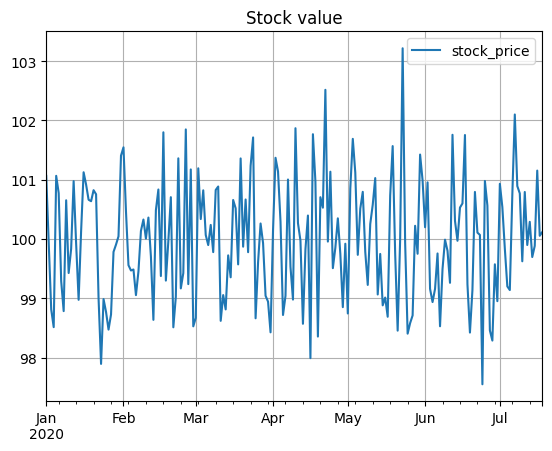

In [524]:
df.plot(title="Stock value",grid=True,legend=True)

### Another useful feature is to be able to display summary statistics of our data set using the ```.describe()```class method

In [525]:
df.describe()

count    200.000000
mean      99.980955
std        0.995957
min       97.548457
25%       99.164367
50%       99.938899
75%      100.743758
max      103.218364
Name: stock_price, dtype: float64

In [526]:
df.describe()["std"]

np.float64(0.9959571034804299)

### **Note:** the desribe method returns a series as well

In [527]:
type(df.describe())

pandas.core.series.Series

### We can also display first/last n rows using ```head(n)``` or ```tail(n)``` that also return series

In [528]:
df.head(5)

2020-01-01    101.064416
2020-01-02     99.938863
2020-01-03     98.811297
2020-01-04     98.512578
2020-01-05    101.066024
Freq: D, Name: stock_price, dtype: float64

In [529]:
type(df.head(5))

pandas.core.series.Series

In [530]:
df.tail(2)

2020-07-17    100.054330
2020-07-18    100.115289
Freq: D, Name: stock_price, dtype: float64

### **Note** that ```head(n)``` or ```tail(n)``` are equivalent to slicing with ```[:n]``` or ```[-n:]``` respectively

---
# Pandas DataFrames
### Before advancing further, let's introduce the concept of a dataframe. A Pandas DataFrame is a collection of Series labelled by the same index, e.g. it could be a collection of Series of Stock prices labelled by their timestamp. 

### To create a DataFrame we use the method ```pd.DataFrame()``` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)


In [531]:
# We create a date range
dates = pd.date_range('20200101', periods=200)
# And some random values for a stock
stock_value=100+np.random.normal(0,1,(200,4))

df = pd.DataFrame(stock_value, index=dates, columns=['stock_a','stock_b','stock_c','stock_d'])

print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,stock_a,stock_b,stock_c,stock_d
2020-01-01,100.761290,99.872385,99.782587,99.164757
2020-01-02,98.568850,101.011953,97.571204,100.526876
2020-01-03,100.029984,99.483075,100.297988,100.704984
2020-01-04,100.029620,99.361135,99.785469,99.698735
2020-01-05,98.141746,101.360107,101.592296,99.518869
...,...,...,...,...
2020-07-14,100.428649,99.971308,99.237245,100.424708
2020-07-15,99.562563,99.504853,101.654062,100.488954
2020-07-16,101.627987,99.963134,98.580062,98.595336
2020-07-17,99.686542,98.936678,100.243817,100.510718


### Let's have a look at some examples looking at the```yfinance``` library
#### In 2025 the YFinance API changed a bit so we need to modify the pandas dataframe that gets returned from the library to be a bit more firendly

In [532]:
import yfinance

AAPL = yfinance.download(["AAPL"],auto_adjust=False,period="5Y" ) # gets Apple's data

[*********************100%***********************]  1 of 1 completed


In [533]:
AAPL.columns.get_level_values('Price')

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [534]:
AAPL.columns=AAPL.columns.swaplevel(0, 1)

AAPL.loc[:,('AAPL')]

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-12-22,128.378876,131.880005,134.410004,129.649994,131.610001,168904800
2020-12-23,127.483330,130.960007,132.429993,130.779999,132.160004,88223700
2020-12-24,128.466476,131.970001,133.460007,131.100006,131.320007,54930100
2020-12-28,133.061188,136.690002,137.339996,133.509995,133.990005,124486200
2020-12-29,131.289505,134.869995,138.789993,134.339996,138.050003,121047300
...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700


In [535]:
#Option 2
AAPL = yfinance.download(["AAPL"],auto_adjust=False,period="5Y")
AAPL=pd.DataFrame(AAPL.values,AAPL.index,columns=AAPL.columns.get_level_values('Price').values)

[*********************100%***********************]  1 of 1 completed


In [536]:
AAPL

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-12-22,128.378922,131.880005,134.410004,129.649994,131.610001,168904800.0
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0
...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700.0


In [537]:
type(AAPL) # Check data typr

pandas.core.frame.DataFrame

### As mentioned, before ```yfinance``` provides us with a dataframe directly with a number of columns, that can then be accessed by typing ```dataframe.columns```, and likewise for the index, which can be accessed using  ```dataframe.index```. The values in turn, can be accessed using the attribute ```dataframe.vales```

In [538]:
AAPL.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [539]:
AAPL.index


DatetimeIndex(['2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-04',
               '2021-01-05', '2021-01-06',
               ...
               '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12',
               '2025-12-15', '2025-12-16', '2025-12-17', '2025-12-18',
               '2025-12-19', '2025-12-22'],
              dtype='datetime64[ns]', name='Date', length=1256, freq=None)

In [540]:
AAPL.values

array([[1.28378922e+02, 1.31880005e+02, 1.34410004e+02, 1.29649994e+02,
        1.31610001e+02, 1.68904800e+08],
       [1.27483322e+02, 1.30960007e+02, 1.32429993e+02, 1.30779999e+02,
        1.32160004e+02, 8.82237000e+07],
       [1.28466507e+02, 1.31970001e+02, 1.33460007e+02, 1.31100006e+02,
        1.31320007e+02, 5.49301000e+07],
       ...,
       [2.72190002e+02, 2.72190002e+02, 2.73630005e+02, 2.66950012e+02,
        2.73609985e+02, 5.16307000e+07],
       [2.73670013e+02, 2.73670013e+02, 2.74600006e+02, 2.69899994e+02,
        2.72149994e+02, 1.44599200e+08],
       [2.71000000e+02, 2.71000000e+02, 2.73880005e+02, 2.70510010e+02,
        2.72859985e+02, 2.19943550e+07]], shape=(1256, 6))

### ***Remark***: ```.values ``` casts a dataframe or series into a numpy array. Note that this operation will return a pure numpy array without the original index

---
# Quick comment on storing and loading dataframes
### Pandas offers a number of format compatibility like ```dataframe.to_csv``` .csv,  ```dataframe.to_pickle``` .pickle etc. The difference between picke and csv is that with pickle python will repect the types of index/values as opposed to csv where it will do a best guess

In [541]:
AAPL.to_csv('AAPL.csv',index=True)
pd.read_csv('AAPL.csv',index_col=0)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-12-22,128.378922,131.880005,134.410004,129.649994,131.610001,168904800.0
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0
...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700.0


### Note that we lost the type of the index

In [542]:
pd.read_csv('AAPL.csv',index_col=0).index

Index(['2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
       '2020-12-30', '2020-12-31', '2021-01-04', '2021-01-05', '2021-01-06',
       ...
       '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12', '2025-12-15',
       '2025-12-16', '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-22'],
      dtype='object', name='Date', length=1256)

In [543]:
AAPL.to_pickle('AAPL.pickle')
pd.read_pickle('AAPL.pickle')

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-12-22,128.378922,131.880005,134.410004,129.649994,131.610001,168904800.0
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0
...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700.0


In [544]:
pd.read_pickle('AAPL.pickle').index

DatetimeIndex(['2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-04',
               '2021-01-05', '2021-01-06',
               ...
               '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12',
               '2025-12-15', '2025-12-16', '2025-12-17', '2025-12-18',
               '2025-12-19', '2025-12-22'],
              dtype='datetime64[ns]', name='Date', length=1256, freq=None)

### Here pickle respects the original index type

---
# Back to DataFrames

## Slicing DataFrames

### Perhaps, not all the information in a dataframe is relevant to us and often case we want to either remove part of it or transform it. Let us start by selecting a single column from the dataframe above. There are a numbers of ways to do this operation:

In [545]:
# Let's assume we are interested in adjclose column in AAPL dataframe
AAPL_close=AAPL.Close # we can type explicitly the name of the column
print(type(AAPL_close))
AAPL_close

<class 'pandas.core.series.Series'>


Date
2020-12-22    131.880005
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
                 ...    
2025-12-16    274.609985
2025-12-17    271.839996
2025-12-18    272.190002
2025-12-19    273.670013
2025-12-22    271.000000
Name: Close, Length: 1256, dtype: float64

In [546]:
# Equivalently we can use 
AAPL_close=AAPL['Close'] # we can type explicitly the name of the column
print(type(AAPL_close))
AAPL_close

<class 'pandas.core.series.Series'>


Date
2020-12-22    131.880005
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
                 ...    
2025-12-16    274.609985
2025-12-17    271.839996
2025-12-18    272.190002
2025-12-19    273.670013
2025-12-22    271.000000
Name: Close, Length: 1256, dtype: float64

### We can also use the loc method, as opposed to series, for dataframes ```.loc``` takes two arguments ```.loc[array_index,array_columns]```

In [547]:
# Equivalently we can use 
AAPL_close=AAPL.loc[:,'Close'] # we can type explicitly the name of the column
print(type(AAPL_close))
AAPL_close

<class 'pandas.core.series.Series'>


Date
2020-12-22    131.880005
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
                 ...    
2025-12-16    274.609985
2025-12-17    271.839996
2025-12-18    272.190002
2025-12-19    273.670013
2025-12-22    271.000000
Name: Close, Length: 1256, dtype: float64

### ***Remark***:  Slicing a dataframe into a single column returns  a Series! Slicing multiple Columns return a DataFrame!

### If we want to obtain a DataFrame as output we can use double brackets with the columns (see below)

In [548]:
AAPL_close=AAPL.loc[:,['Close']]
print(type(AAPL_close))
AAPL_close

<class 'pandas.core.frame.DataFrame'>


,Close
Date,
2020-12-22,131.880005
2020-12-23,130.960007
2020-12-24,131.970001
2020-12-28,136.690002
2020-12-29,134.869995
...,...
2025-12-16,274.609985
2025-12-17,271.839996
2025-12-18,272.190002


In [549]:
AAPL[['Close']]

,Close
Date,
2020-12-22,131.880005
2020-12-23,130.960007
2020-12-24,131.970001
2020-12-28,136.690002
2020-12-29,134.869995
...,...
2025-12-16,274.609985
2025-12-17,271.839996
2025-12-18,272.190002


In [550]:
#Let's slice high and low
AAPL_high_low=AAPL.loc[:,['Low','High']]
print(type(AAPL_high_low))
AAPL_high_low

<class 'pandas.core.frame.DataFrame'>


,Low,High
Date,,
2020-12-22,129.649994,134.410004
2020-12-23,130.779999,132.429993
2020-12-24,131.100006,133.460007
2020-12-28,133.509995,137.339996
2020-12-29,134.339996,138.789993
...,...,...
2025-12-16,271.790009,275.500000
2025-12-17,271.640015,276.160004
2025-12-18,266.950012,273.630005


## Slicing using integer indexing

### Sometimes we might not care about the specific name that a column has or the especific indexing convention e.g. we might just be interest in the 1st value of the 1st column. We can use the ```.iloc``` (integer locator) method to access such elements using the convention ```.iloc[array_integer_index,array_integer_columns]``` same **as if we where slicing a 2D numpy array**

In [551]:
AAPL.iloc[:,2]# all rows only 3rd column

Date
2020-12-22    134.410004
2020-12-23    132.429993
2020-12-24    133.460007
2020-12-28    137.339996
2020-12-29    138.789993
                 ...    
2025-12-16    275.500000
2025-12-17    276.160004
2025-12-18    273.630005
2025-12-19    274.600006
2025-12-22    273.880005
Name: High, Length: 1256, dtype: float64

In [552]:
AAPL.iloc[2,:]# 3rd row all columns

Adj Close    1.284665e+02
Close        1.319700e+02
High         1.334600e+02
Low          1.311000e+02
Open         1.313200e+02
Volume       5.493010e+07
Name: 2020-12-24 00:00:00, dtype: float64

In [553]:
AAPL.iloc[2:4,2:4]# 3-4 rows and 3-4 columns

,High,Low
Date,,
2020-12-24,133.460007,131.100006
2020-12-28,137.339996,133.509995


---
# ```.loc``` vs ```.at```  | ```.iloc``` vs ```.iat```

### What is the difference between ```.loc``` and ```.at```? ```loc``` returns either a scalar value or an array, whereas ```at``` only works for scalar retrieval

### What is the difference between ```.iloc``` and ```.iat```? ```iloc``` returns either a scalar value or an array, whereas ```iat``` only works for scalar retrieval

In [554]:
AAPL.loc[:,"Close"]

Date
2020-12-22    131.880005
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
                 ...    
2025-12-16    274.609985
2025-12-17    271.839996
2025-12-18    272.190002
2025-12-19    273.670013
2025-12-22    271.000000
Name: Close, Length: 1256, dtype: float64

In [555]:
AAPL.loc[:, "Close"]

Date
2020-12-22    131.880005
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
                 ...    
2025-12-16    274.609985
2025-12-17    271.839996
2025-12-18    272.190002
2025-12-19    273.670013
2025-12-22    271.000000
Name: Close, Length: 1256, dtype: float64

In [556]:
%timeit AAPL.at["2023-10-30","Close"]

25.7 μs ± 523 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [557]:
%timeit AAPL.loc["2023-10-30","Close"]

102 μs ± 5.58 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### **Note**: ```iat``` and ```at``` are much more performant for scalar value retrieval 

---
# Creating new columns
### To create new columns we simply write the name of the new column in square brackets ```DataFrame["new_column_name"]=values``` and assign a value e.g

In [558]:
AAPL["log_stock_close"]=np.log(AAPL.Close)

In [559]:
AAPL.head(5)

,Adj Close,Close,High,Low,Open,Volume,log_stock_close
Date,,,,,,,
2020-12-22,128.378922,131.880005,134.410004,129.649994,131.610001,168904800.0,4.881892
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0,4.874892
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0,4.882575
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0,4.917716
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0,4.904311


### Note that we need to assign an array with the same length otherwise it will throw an error:

In [560]:
# AAPL['log_stock_close']=np.array([1,2]) #Not valid

# Some useful functions
### Pandas provides mean, std,sum,min,max... and a number of functions that can be applied to both axis, similar to numpy

In [561]:
AAPL.mean(axis=0) #mean across columns

Adj Close          1.788169e+02
Close              1.808127e+02
High               1.826040e+02
Low                1.788478e+02
Open               1.806379e+02
Volume             7.023470e+07
log_stock_close    5.175099e+00
dtype: float64

In [562]:
AAPL.std(axis=0) #std across columns

Adj Close          3.971985e+01
Close              3.887577e+01
High               3.909575e+01
Low                3.858844e+01
Open               3.882515e+01
Volume             3.002635e+07
log_stock_close    2.103256e-01
dtype: float64

In [563]:
AAPL.sum(axis=0) #sum across columns

Adj Close          2.245941e+05
Close              2.271007e+05
High               2.293506e+05
Low                2.246328e+05
Open               2.268812e+05
Volume             8.821478e+10
log_stock_close    6.499924e+03
dtype: float64

In [564]:
AAPL.min(axis=0) #minimum value across columns

Adj Close          1.134402e+02
Close              1.163600e+02
High               1.204000e+02
Low                1.162100e+02
Open               1.190300e+02
Volume             2.013560e+07
log_stock_close    4.756689e+00
dtype: float64

In [565]:
AAPL.max(axis=0) #minimum value across columns

Adj Close          2.861900e+02
Close              2.861900e+02
High               2.886200e+02
Low                2.833000e+02
Open               2.862000e+02
Volume             3.186799e+08
log_stock_close    5.656656e+00
dtype: float64

---
# Boolean slicing

### We can also slice a dataframe whenever a boolean condition is satisfied. To do so we can use the ```.loc[boolean_array,columns_array]``` method 

In [566]:
# Filter data by volume
boolean_condition=AAPL.Volume>400000000
print(boolean_condition)
AAPL.loc[boolean_condition,:]

Date
2020-12-22    False
2020-12-23    False
2020-12-24    False
2020-12-28    False
2020-12-29    False
              ...  
2025-12-16    False
2025-12-17    False
2025-12-18    False
2025-12-19    False
2025-12-22    False
Name: Volume, Length: 1256, dtype: bool


,Adj Close,Close,High,Low,Open,Volume,log_stock_close
Date,,,,,,,


---
# Chaining multiple boolean conditions with the keyword ```&```

### If we want to concatenate mutiple condition we need to use the **bitwise and** operator defined by ```&```
### If we want to concatenate mutiple alternative condition we need to use the **bitwise or** operator defined by ```|```

In [567]:
# Filter data by volume
boolean_condition1=AAPL.Volume>4000000
boolean_condition2=AAPL.Volume<90000000

AAPL.loc[boolean_condition1 & boolean_condition2,:]

,Adj Close,Close,High,Low,Open,Volume,log_stock_close
Date,,,,,,,
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0,4.874892
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0,4.882575
2021-01-13,127.415169,130.889999,131.449997,128.490005,128.759995,88636800.0,4.874357
2021-02-02,131.406311,134.990005,136.309998,134.610001,135.729996,83305400.0,4.905201
2021-02-03,130.384171,133.940002,135.770004,133.610001,135.759995,89880900.0,4.897392
...,...,...,...,...,...,...,...
2025-12-15,274.109985,274.109985,280.149994,272.839996,280.149994,50409100.0,5.613529
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0,5.615352
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0,5.605214


In [568]:
df2=AAPL
print(AAPL.iloc[0,0])
df2.iloc[0,0]=0
print(AAPL.iloc[0,0])

128.37892150878906
0.0


In [569]:
df2

,Adj Close,Close,High,Low,Open,Volume,log_stock_close
Date,,,,,,,
2020-12-22,0.000000,131.880005,134.410004,129.649994,131.610001,168904800.0,4.881892
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0,4.874892
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0,4.882575
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0,4.917716
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0,4.904311
...,...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0,5.615352
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0,5.605214
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700.0,5.606500


In [570]:
AAPL

,Adj Close,Close,High,Low,Open,Volume,log_stock_close
Date,,,,,,,
2020-12-22,0.000000,131.880005,134.410004,129.649994,131.610001,168904800.0,4.881892
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0,4.874892
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0,4.882575
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0,4.917716
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0,4.904311
...,...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0,5.615352
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0,5.605214
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700.0,5.606500


In [571]:
#Exactly the same problem as arrays
a=np.array([1,2,3])
b=a
b[0]=10
print(a[0])

10


### As you can see copies of dataframes are mutable in the value, so one needs to be careful when making copies and modifying them as it also changes the root values. You can sort this out, by using the  ```.copy() ``` method

In [572]:
df2=AAPL.copy()
print(AAPL.iloc[1,0])
df2.iloc[1,0]=0
print(AAPL.iloc[1,0])

127.48332214355469
127.48332214355469


In [573]:
idx = AAPL.index.to_list()
idx[0] = "1980-11-11"
AAPL.index = idx


### Indices on the other hand, are inmutable. This means that if we want to make a change to the index we need to redefine the entire index
---

#  info(), describe() and plot()
### Similar to pandas Series we can use describe and plot methods on DataFames as well as info

#### We discussed in the beginning of the session that Pandas has significant memory consumption, let´s check that

In [574]:
import sys
print(f" Size of Numpy values: {sys.getsizeof(AAPL.values.copy())/1000:.2f} KB")
print(f" Size of pandas dataframe: {sys.getsizeof(AAPL)/1000:.2f} KB")

 Size of Numpy values: 70.46 KB
 Size of pandas dataframe: 231.06 KB


### As you can see the pandas object takes twice as much space, we can compara these values with the methods that arrays and dataframes provide to estimate the memory consumption

In [575]:
print(f"Numpy nbytes size estimate {AAPL.values.nbytes/1000:.2f}KB")

Numpy nbytes size estimate 70.34KB


In [576]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1256 entries, 1980-11-11 to 2025-12-22 00:00:00
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        1256 non-null   float64
 1   Close            1256 non-null   float64
 2   High             1256 non-null   float64
 3   Low              1256 non-null   float64
 4   Open             1256 non-null   float64
 5   Volume           1256 non-null   float64
 6   log_stock_close  1256 non-null   float64
dtypes: float64(7)
memory usage: 78.5+ KB


#### Numpy and pandas estimates are slightly smaller, but reanonably close. The info() method above gives high level information about the dataframe, like data types non-null count etc.

In [577]:
AAPL.describe()

,Adj Close,Close,High,Low,Open,Volume,log_stock_close
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.000000
mean,178.714709,180.812683,182.604013,178.847771,180.637882,7.023470e+07,5.175099
std,40.013841,38.875771,39.095748,38.588438,38.825153,3.002635e+07,0.210326
min,0.000000,116.360001,120.400002,116.209999,119.029999,2.013560e+07,4.756689
25%,145.889080,148.789993,150.007496,147.150002,148.575001,4.855662e+07,5.002536
50%,171.469345,173.949997,175.325005,171.980003,173.349998,6.338200e+07,5.158768
75%,209.523865,210.050003,212.602505,208.197498,210.150005,8.499615e+07,5.347346
max,286.190002,286.190002,288.619995,283.299988,286.200012,3.186799e+08,5.656656


<Axes: title={'center': 'AAPL daily OHLCV'}>

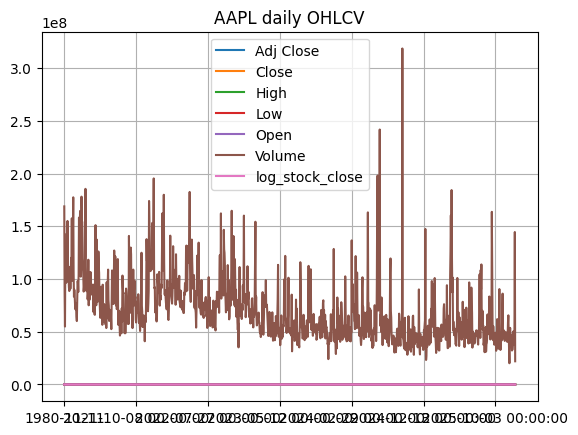

In [578]:
#AAPL_high_low=AAPL.loc[dates_2019,['low','high']]
#print(type(AAPL_high_low))
#Plot the data
AAPL.plot(grid=True,title='AAPL daily OHLCV')

### The scale of the different columns is an issues here, but we can select the columns that we care about to make a cleaner plot

<Axes: title={'center': 'AAPL daily OHLC'}>

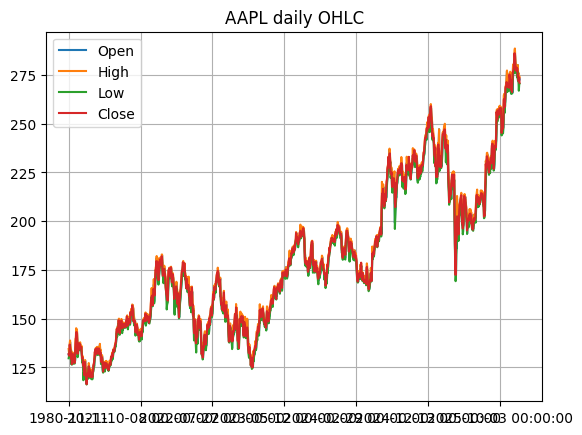

In [579]:
AAPL[["Open","High","Low","Close"]].plot(grid=True,title='AAPL daily OHLC')

###  We will see more on plotting later, but this gives a simple tool to visualize quickly a dataset
---

# Dates and Time slicing

### The python standard library includes ```datetime``` module to handle dates. We can create any date using the method ```datetime.datetime(year,month,day)```

In [580]:
import datetime
import numpy as np
#I strongly recommend to have a look at datetime module as you will be often dealing with this when using time-series data 
date=datetime.datetime(2020, 5, 17)
print(date.year)
print(date.month)
print(date.day)

2020
5
17


### If we want to select a range of dates we can use boolean slicing with datetime objects

In [581]:
# #Not allowed
# AAPL.index>=datetime.datetime(2019, 1, 1)

### Note that in some previous Numpy 2.X versions this operation failed. Seems that it works back, make sure you are using the right versioning.

## The way to slice by date is using string in the form "YYYY-MM-DD"

In [582]:
AAPL.index = pd.to_datetime(AAPL.index)
AAPL_2023 = AAPL.loc[(AAPL.index >= "2023-01-01") & (AAPL.index < "2024-01-01")]
# or simpler:
AAPL_2023 = AAPL.loc["2023-01-01":"2023-12-31"]



<class 'pandas.core.frame.DataFrame'>


<Axes: title={'center': 'AAPL 2019 daily high and low'}>

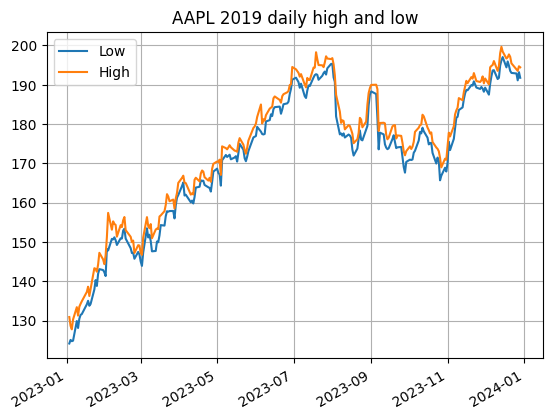

In [583]:
import datetime
# We select just 2019 dates
dates_2019=AAPL.index[(AAPL.index>="2023-01-01") & (AAPL.index<"2024-01-01")]
#We slice the dataframe
AAPL_high_low=AAPL.loc[dates_2019,['Low','High']]
print(type(AAPL_high_low))
#Plot the data
AAPL_high_low.plot(grid=True,title='AAPL 2019 daily high and low')

## **Remark**: The reason why we use datetime objects is because the index is also a datetime object, which is the default index in yfinance. However, if dates are represented as strings, once use string comparison (see below) since dates follow lexicographic ordering, which is the default comparison straegy for strings

In [584]:
date="2022-02-02"

print(date>"2023-02-02")

print(date>"2021-01-01")

False
True


In [585]:
string_index=AAPL.index.astype(str)#cast datetime to string
string_index

Index(['1980-11-11', '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
       '2020-12-30', '2020-12-31', '2021-01-04', '2021-01-05', '2021-01-06',
       ...
       '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12', '2025-12-15',
       '2025-12-16', '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-22'],
      dtype='object', length=1256)

In [586]:
string_index>"2023-01-01"# we can use string comparisson

array([False, False, False, ...,  True,  True,  True], shape=(1256,))

### It doesn't really matter which date representation you use (either python datetime or string), **but be aware of the difference!!!**
---

# Some useful functions for financial applications: Diff, Shift and pct_change()
### ```dataframe.diff(n)``` computes the difference with respect to the tow n postitions below. Shift ```dataframe.shift(n)``` displaces the dataframe $n$ rows down. ```dataframe.pct_change()``` computes returns

In [587]:
AAPL

,Adj Close,Close,High,Low,Open,Volume,log_stock_close
1980-11-11,0.000000,131.880005,134.410004,129.649994,131.610001,168904800.0,4.881892
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0,4.874892
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0,4.882575
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0,4.917716
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0,4.904311
...,...,...,...,...,...,...,...
2025-12-16,274.609985,274.609985,275.500000,271.790009,272.820007,37648600.0,5.615352
2025-12-17,271.839996,271.839996,276.160004,271.640015,275.010010,50138700.0,5.605214
2025-12-18,272.190002,272.190002,273.630005,266.950012,273.609985,51630700.0,5.606500
2025-12-19,273.670013,273.670013,274.600006,269.899994,272.149994,144599200.0,5.611923


In [588]:
AAPL.Close.diff(1)

1980-11-11         NaN
2020-12-23   -0.919998
2020-12-24    1.009995
2020-12-28    4.720001
2020-12-29   -1.820007
                ...   
2025-12-16    0.500000
2025-12-17   -2.769989
2025-12-18    0.350006
2025-12-19    1.480011
2025-12-22   -2.670013
Name: Close, Length: 1256, dtype: float64

In [589]:
AAPL.Close.shift(1)

1980-11-11           NaN
2020-12-23    131.880005
2020-12-24    130.960007
2020-12-28    131.970001
2020-12-29    136.690002
                 ...    
2025-12-16    274.109985
2025-12-17    274.609985
2025-12-18    271.839996
2025-12-19    272.190002
2025-12-22    273.670013
Name: Close, Length: 1256, dtype: float64

In [590]:
AAPL['daily_return'] = AAPL["Close"].pct_change()

In [591]:
AAPL.head()

,Adj Close,Close,High,Low,Open,Volume,log_stock_close,daily_return
1980-11-11,0.000000,131.880005,134.410004,129.649994,131.610001,168904800.0,4.881892,NaN
2020-12-23,127.483322,130.960007,132.429993,130.779999,132.160004,88223700.0,4.874892,-0.006976
2020-12-24,128.466507,131.970001,133.460007,131.100006,131.320007,54930100.0,4.882575,0.007712
2020-12-28,133.061234,136.690002,137.339996,133.509995,133.990005,124486200.0,4.917716,0.035766
2020-12-29,131.289536,134.869995,138.789993,134.339996,138.050003,121047300.0,4.904311,-0.013315


----
# Iterating over Dataframe rows
### Sometime our analysis requires to go row by row in a dataframe to perform a numerical operation. To do this we can use ```iterrows``` or ```itertuples``` . ```iterrows``` returns a (index,row) tuple whereas ```itertuples``` returns a objects whose index attribute gives the index and the rest of the atributes follow the column names

In [592]:
import time
high_low_mid=np.zeros(len(AAPL))
i=0
start_time=time.time()
for index,row in AAPL.iterrows():
    high_low_mid[i]=0.5*(row.High+row.Low)
    i+=1
print("iterrows took", time.time()-start_time,"seconds")

iterrows took 0.06621384620666504 seconds


In [593]:
print(high_low_mid)

[132.02999878 131.60499573 132.28000641 ... 270.29000854 272.25
 272.19500732]


In [594]:
high_low_mid=np.zeros(len(AAPL))
index=0
start_time=time.time()
for row in AAPL.itertuples():    
    high_low_mid[index]=0.5*(row.High+row.Low)
    index+=1
print("itertuples took", time.time()-start_time,"seconds")

itertuples took 0.0032837390899658203 seconds


In [595]:
print(high_low_mid)

[132.02999878 131.60499573 132.28000641 ... 270.29000854 272.25
 272.19500732]


### **Note:** If going row by row is necessary (as we will see in a minute, vectorisation is always preferred), most of the time `itertuples` is much more efficient 
---

# Vectorisation in DataFrame Columns and slices
### As mentioned in the beginning of the session, internally Pandas stores the data as numpy arrays. Hence, we can make use of vectorisation to speed up computations

In [596]:
%timeit high_low_mid=0.5*(AAPL.High+AAPL.Low)

147 μs ± 8.76 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [597]:
high_low_mid=0.5*(AAPL.High+AAPL.Low)
high_low_mid.values

array([132.02999878, 131.60499573, 132.28000641, ..., 270.29000854,
       272.25      , 272.19500732], shape=(1256,))

In [598]:
#We can apply the same pinciple if we want a slice corresponding to 2019 data

dates_2019=AAPL.index[(AAPL.index>="2019-01-01") & (AAPL.index<"2020-01-01")]

%timeit high_low_mid_2019=0.5*(AAPL.High[dates_2019]+AAPL.Low[dates_2019])# gives some performance improvement

%timeit high_low_mid_2019=0.5*(AAPL.loc[dates_2019,'High']+AAPL.loc[dates_2019,'Low'])



699 μs ± 109 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
629 μs ± 19.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---
# Complex functions and  ```apply```
### Using ```dataframe.apply``` we can vectorise any user-defined function that supports vectorisation and apply it indexwise (axis=1) or columnwise (axis=0). One can further optimize the method by setting ```raw=True``` which will make the assumption that objects are numpy arrays internally

In [599]:
AAPL=AAPL.loc[:,['Open','High','Low','Close']]

In [600]:
# Columnwuse
def my_func(x):
    # Function will be applied columnwise x represents the entire column
    return x.max() -x.min() 

%timeit AAPL.apply(my_func,axis=0,raw=False)
%timeit AAPL.apply(my_func,axis=0,raw=True)

AAPL.apply(my_func,axis=0,raw=True)# For each column do maximum -minimum value
    

365 μs ± 8.76 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
119 μs ± 1.85 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Open     167.170013
High     168.219994
Low      167.089989
Close    169.830002
dtype: float64

In [601]:
def my_func_high_low_mid(x):
    
     # Function will be applied rowise, x the entire 
    return 0.5*(x.High+x.Low) #here we assume x mantains the column structure

def my_func_high_low_mid2(x):
    # Function will be applied rowise, x the entire row casted to numpy array
    return 0.5*(x[1]+x[2]) # We need to use integer slicing

%timeit AAPL.apply(my_func_high_low_mid,axis=1,raw=False)
%timeit AAPL.apply(my_func_high_low_mid2,axis=1,raw=True)

22.3 ms ± 253 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.17 ms ± 18.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### As you can see ```raw=True``` can give dramatic performance improvements as data will be treated as a numpy array

---

# Variable transformations 

In many data workflows (econometrics / ML / finance), **transforming variables** means creating *new* variables as functions of existing ones:

- **Single-variable transforms**: `new = f(old)` (e.g., log, differences, growth rates).
- **Multi-variable transforms**: `new = f(old1, old2, ...)` (e.g., ratios, interactions, mid-price).

In pandas, most transformations are best done with **vectorized operations** (fast and readable). `apply` can be useful for complex row-wise logic, but it is usually slower than vectorized code.

Below are common transformations using the `AAPL` DataFrame.

In [602]:
# Make an explicit copy before adding many new columns (good practice)
AAPL = AAPL.copy()

# 1) Log transform: compresses scale, often stabilizes variance
AAPL["log_close"] = np.log(AAPL["Close"])

# 2) First difference: change in the level from t-1 to t
AAPL["close_diff_1"] = AAPL["Close"].diff(1)

# 3) Lag: yesterday's value aligned with today (useful for regressions / models)
AAPL["close_lag_1"] = AAPL["Close"].shift(1)

# 4) Simple return: percentage change from t-1 to t
AAPL["ret_close"] = AAPL["Close"].pct_change()

# 5) Log return: difference in log prices (approximately equal to simple return for small changes)
AAPL["log_ret_close"] = np.log(AAPL["Close"]).diff(1)

# 6) Mid price: combines High and Low into a single "central" price measure
AAPL["mid_price"] = 0.5 * (AAPL["High"] + AAPL["Low"])

# 7) Range features: measures intraday movement
AAPL["hl_range"] = AAPL["High"] - AAPL["Low"]
AAPL["hl_range_pct"] = (AAPL["High"] - AAPL["Low"]) / AAPL["Close"]

# 8) Rolling features: moving average (mean) and rolling volatility (std dev)
AAPL["ret_5d_ma"] = AAPL["ret_close"].rolling(5).mean()
AAPL["ret_20d_vol"] = AAPL["ret_close"].rolling(20).std()

# 9) Clipping (simple outlier handling): caps extreme returns at the 1st/99th percentiles
lo, hi = AAPL["ret_close"].quantile([0.01, 0.99])
AAPL["ret_close_clipped"] = AAPL["ret_close"].clip(lower=lo, upper=hi)

# 10) Indicator + interaction:
#     - indicator: 1 if Close is above its 20-day moving average, else 0
#     - interaction: return scaled by the (percentage) high-low range
AAPL["above_20d_ma"] = (AAPL["Close"] > AAPL["Close"].rolling(20).mean()).astype(int)
AAPL["ret_x_range"] = AAPL["ret_close"] * AAPL["hl_range_pct"]

AAPL.head()

,Open,High,Low,Close,log_close,close_diff_1,close_lag_1,ret_close,log_ret_close,mid_price,hl_range,hl_range_pct,ret_5d_ma,ret_20d_vol,ret_close_clipped,above_20d_ma,ret_x_range
1980-11-11,131.610001,134.410004,129.649994,131.880005,4.881892,NaN,NaN,NaN,NaN,132.029999,4.760010,0.036093,NaN,NaN,NaN,0,NaN
2020-12-23,132.160004,132.429993,130.779999,130.960007,4.874892,-0.919998,131.880005,-0.006976,-0.007000,131.604996,1.649994,0.012599,NaN,NaN,-0.006976,0,-0.000088
2020-12-24,131.320007,133.460007,131.100006,131.970001,4.882575,1.009995,130.960007,0.007712,0.007683,132.280006,2.360001,0.017883,NaN,NaN,0.007712,0,0.000138
2020-12-28,133.990005,137.339996,133.509995,136.690002,4.917716,4.720001,131.970001,0.035766,0.035141,135.424995,3.830002,0.028020,NaN,NaN,0.035766,0,0.001002
2020-12-29,138.050003,138.789993,134.339996,134.869995,4.904311,-1.820007,136.690002,-0.013315,-0.013404,136.564995,4.449997,0.032995,NaN,NaN,-0.013315,0,-0.000439
